# Running the minimal feature set on best models

In [416]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score, 
                            classification_report)
from pickle import load
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from scipy.stats import mannwhitneyu


import sys
sys.path.append('../') 
import importlib
import os
from joblib import dump, load
import feature_sets
importlib.reload(feature_sets)
import feature_sets_rnfl
importlib.reload(feature_sets_rnfl)
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.inspection import permutation_importance
import shap
import sys
from sklearn.linear_model import SGDClassifier
import optuna_util
importlib.reload(optuna_util)
from optuna_util import run_optuna_studies

from sklearn.metrics import roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, average_precision_score

feature_set_dfs = []
optuna_results_dir = './optuna_results'
fitted_models_dir = './best_hyperparams_fitted/'

<br>

## 3 year tte

In [22]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_3year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_3year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_3year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_3year_tte.pkl')
minimal_features_rfecv_3year_tte = feature_sets.minimal_features_rfecv_3year_tte

<br>

### run 3 year tte model on minimal feature set (before class balance)

AUROC: 0.8808\
Precision: 0.0091\
Recall: 0.7917\
F1 Score: 0.0181



In [9]:
# old model
# Make sure we only use the selected features
#minimal_features_rfecv_3year_tte = feature_sets.OD_features
X_train_selected = X_train[minimal_features_rfecv_3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_3year_tte['feature']]



# Initialize and train logistic regression model using Optuna optimization
from sklearn.linear_model import SGDClassifier
import optuna
from optuna_util import LogisticRegressionSGD_OptunaObjective 

# Create the objective function for Optuna
objective = LogisticRegressionSGD_OptunaObjective(
    X=X_train_selected, 
    y=y_train, 
    n_cv_folds=5, 
    scoring_metric='roc_auc'
)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Train final model with best parameters
final_model = SGDClassifier(
    loss='log_loss',
    penalty='l2',
    fit_intercept=True,
    tol=1e-4,
    n_iter_no_change=5,
    **best_params,
    random_state=1,
    class_weight='balanced'
)

# Fit the model
final_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(final_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_3year_tte['feature'],
        'Coefficient': final_model.coef_[0],
        'Abs Coefficient': abs(final_model.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    

[I 2025-09-09 04:04:02,465] A new study created in memory with name: no-name-71d3f91c-c5b3-4793-8a50-ab79c2851ac2


{'alpha': FloatDistribution(high=10.0, log=True, low=1e-06, step=None), 'learning_rate': CategoricalDistribution(choices=('optimal', 'constant', 'adaptive')), 'eta0': FloatDistribution(high=0.1, log=True, low=0.001, step=None)}

Starting trial 0
{'alpha': 0.0009456346972654688, 'learning_rate': 'constant', 'eta0': 0.04731362509927071, 'loss': 'log_loss', 'penalty': 'l2', 'fit_intercept': True, 'tol': 0.0001, 'n_iter_no_change': 5}
Running CV in parallel
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[I 2025-09-09 04:04:04,641] Trial 0 finished with value: 0.7759275127740234 and parameters: {'alpha': 0.0009456346972654688, 'learning_rate': 'constant', 'eta0': 0.04731362509927071}. Best is trial 0 with value: 0.7759275127740234.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    2.1s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    2.1s finished
CV=0 | roc_auc 0.725 | rolling mean 0.725
CV=1 | roc_auc 0.801 | rolling mean 0.763
CV=2 | roc_auc 0.745 | rolling mean 0.757
CV=3 | roc_auc 0.833 | rolling mean 0.776
CV=4 | roc_auc 0.776 | rolling mean 0.776
Finished trial 0
roc_auc 0.776 (0.725 - 0.833)
optimal_threshold 0.002 (0.001 - 0.004)
sensitivity_recall 0.788 (0.684 - 0.838)
specificity 0.669 (0.581 - 0.768)
ppv_precision 0.005 (0.004 - 0.007)
npv 0.999 (0.999 - 1.000)
f1_score 0.011 (0.008 - 0.015)
pr_auc 0.015 (0.005 - 0.039)

Starting trial 1
{'alpha': 0.005773539446981358, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2', 'fit_intercept': True, 'tol': 0.0001, 'n_iter_no_change': 5}
Running CV in parallel
[Parallel(n_jobs

[I 2025-09-09 04:04:06,611] Trial 1 finished with value: 0.49782561255083035 and parameters: {'alpha': 0.005773539446981358, 'learning_rate': 'optimal'}. Best is trial 0 with value: 0.7759275127740234.


[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    1.8s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.9s finished
CV=0 | roc_auc 0.427 | rolling mean 0.427
CV=1 | roc_auc 0.446 | rolling mean 0.437
CV=2 | roc_auc 0.615 | rolling mean 0.496
CV=3 | roc_auc 0.494 | rolling mean 0.495
CV=4 | roc_auc 0.508 | rolling mean 0.498
Finished trial 1
roc_auc 0.498 (0.427 - 0.615)
optimal_threshold 0.003 (0.003 - 0.003)
sensitivity_recall 0.347 (0.105 - 0.595)
specificity 0.772 (0.521 - 0.947)
ppv_precision 0.004 (0.003 - 0.004)
npv 0.998 (0.998 - 0.998)
f1_score 0.007 (0.005 - 0.008)
pr_auc 0.002 (0.002 - 0.003)

Starting trial 2
{'alpha': 1.678913095830944e-05, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2', 'fit_intercept': True, 'tol': 0.0001, 'n_iter_no_change': 5}
Running CV in parallel
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[I 2025-09-09 04:04:06,852] Trial 2 finished with value: 0.8578673687509314 and parameters: {'alpha': 1.678913095830944e-05, 'learning_rate': 'optimal'}. Best is trial 2 with value: 0.8578673687509314.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.07082343101501465s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.1s finished
CV=0 | roc_auc 0.801 | rolling mean 0.801
CV=1 | roc_auc 0.898 | rolling mean 0.849
CV=2 | roc_auc 0.829 | rolling mean 0.842
CV=3 | roc_auc 0.895 | rolling mean 0.855
CV=4 | roc_auc 0.867 | rolling mean 0.858
Finished trial 2
roc_auc 0.858 (0.801 - 0.898)
optimal_threshold 0.004 (0.002 - 0.006)
sensitivity_recall 0.803 (0.711 - 0.868)
specificity 0.794 (0.747 - 0.831)
ppv_precision 0.009 (0.006 - 0.011)
npv 0.999 (0.999 - 1.000)
f1_score 0.017 (0.012 - 0.022)
pr_auc 0.031 (0.025 - 0.040)

Starting trial 3
{'alpha': 0.4548214949521073, 'learning_rate': 'adaptive', 'eta0': 0.035598704290038655, 'loss': 'log_

[I 2025-09-09 04:04:07,203] Trial 3 finished with value: 0.7854037127259975 and parameters: {'alpha': 0.4548214949521073, 'learning_rate': 'adaptive', 'eta0': 0.035598704290038655}. Best is trial 2 with value: 0.8578673687509314.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Batch computation too fast (0.18370938301086426s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished
CV=0 | roc_auc 0.749 | rolling mean 0.749
CV=1 | roc_auc 0.839 | rolling mean 0.794
CV=2 | roc_auc 0.730 | rolling mean 0.773
CV=3 | roc_auc 0.824 | rolling mean 0.785
CV=4 | roc_auc 0.785 | rolling mean 0.785
Finished trial 3
roc_auc 0.785 (0.730 - 0.839)
optimal_threshold 0.002 (0.002 - 0.002)
sensitivity_recall 0.786 (0.622 - 0.868)
specificity 0.681 (0.466 - 0.829)
ppv_precision 0.006 (0.004 - 0.010)
npv 0.999 (0.999 - 0.999)
f1_score 0.012 (0.007 - 0.020)
pr_auc 0.012 (0.009 - 0.018)

Starting trial 4
{'alpha': 0.00587458889558863, 'learning_rate': 'constant', 'eta0': 0.015441135035122813, 'loss': 'log

[I 2025-09-09 04:04:07,432] Trial 4 finished with value: 0.7739457990197683 and parameters: {'alpha': 0.00587458889558863, 'learning_rate': 'constant', 'eta0': 0.015441135035122813}. Best is trial 2 with value: 0.8578673687509314.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.06265664100646973s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.1s finished
CV=0 | roc_auc 0.697 | rolling mean 0.697
CV=1 | roc_auc 0.830 | rolling mean 0.763
CV=2 | roc_auc 0.751 | rolling mean 0.759
CV=3 | roc_auc 0.819 | rolling mean 0.774
CV=4 | roc_auc 0.773 | rolling mean 0.774
Finished trial 4
roc_auc 0.774 (0.697 - 0.830)
optimal_threshold 0.002 (0.002 - 0.002)
sensitivity_recall 0.814 (0.789 - 0.865)
specificity 0.652 (0.553 - 0.811)
ppv_precision 0.006 (0.004 - 0.009)
npv 0.999 (0.999 - 0.999)
f1_score 0.011 (0.008 - 0.018)
pr_auc 0.009 (0.004 - 0.014)

Starting trial 5
{'alpha': 3.078476606054477e-06, 'learning_rate': 'constant', 'eta0': 0.01128772473920394, 'loss': 'lo

[I 2025-09-09 04:04:07,682] Trial 5 finished with value: 0.7435700216812684 and parameters: {'alpha': 3.078476606054477e-06, 'learning_rate': 'constant', 'eta0': 0.01128772473920394}. Best is trial 2 with value: 0.8578673687509314.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.08244657516479492s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.1s finished
CV=0 | roc_auc 0.674 | rolling mean 0.674
CV=1 | roc_auc 0.760 | rolling mean 0.717
CV=2 | roc_auc 0.753 | rolling mean 0.729
CV=3 | roc_auc 0.740 | rolling mean 0.732
CV=4 | roc_auc 0.791 | rolling mean 0.744
Finished trial 5
roc_auc 0.744 (0.674 - 0.791)
optimal_threshold 0.002 (0.002 - 0.003)
sensitivity_recall 0.740 (0.579 - 0.811)
specificity 0.667 (0.472 - 0.833)
ppv_precision 0.005 (0.003 - 0.008)
npv 0.999 (0.999 - 0.999)
f1_score 0.011 (0.007 - 0.015)
pr_auc 0.012 (0.005 - 0.037)

Starting trial 6
{'alpha': 2.3020726442023916e-06, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2', 'fi

[I 2025-09-09 04:04:07,962] Trial 6 finished with value: 0.8625593294247021 and parameters: {'alpha': 2.3020726442023916e-06, 'learning_rate': 'optimal'}. Best is trial 6 with value: 0.8625593294247021.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Batch computation too fast (0.12516069412231445s.) Setting batch_size=2.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished
CV=0 | roc_auc 0.806 | rolling mean 0.806
CV=1 | roc_auc 0.896 | rolling mean 0.851
CV=2 | roc_auc 0.847 | rolling mean 0.850
CV=3 | roc_auc 0.878 | rolling mean 0.857
CV=4 | roc_auc 0.886 | rolling mean 0.863
Finished trial 6
roc_auc 0.863 (0.806 - 0.896)
optimal_threshold 0.004 (0.000 - 0.011)
sensitivity_recall 0.798 (0.757 - 0.838)
specificity 0.820 (0.730 - 0.891)
ppv_precision 0.011 (0.006 - 0.016)
npv 0.999 (0.999 - 1.000)
f1_score 0.021 (0.012 - 0.032)
pr_auc 0.045 (0.030 - 0.077)

Starting trial 7
{'alpha': 0.08966321027965468, 'learning_rate': 'adaptive', 'eta0': 0.061106035510129136, 'loss': 'log

[I 2025-09-09 04:04:08,312] Trial 7 finished with value: 0.7884648351651039 and parameters: {'alpha': 0.08966321027965468, 'learning_rate': 'adaptive', 'eta0': 0.061106035510129136}. Best is trial 6 with value: 0.8625593294247021.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.2s finished
CV=0 | roc_auc 0.750 | rolling mean 0.750
CV=1 | roc_auc 0.848 | rolling mean 0.799
CV=2 | roc_auc 0.734 | rolling mean 0.777
CV=3 | roc_auc 0.828 | rolling mean 0.790
CV=4 | roc_auc 0.783 | rolling mean 0.788
Finished trial 7
roc_auc 0.788 (0.734 - 0.848)
optimal_threshold 0.002 (0.002 - 0.002)
sensitivity_recall 0.744 (0.622 - 0.842)
specificity 0.732 (0.581 - 0.839)
ppv_precision 0.007 (0.004 - 0.011)
npv 0.999 (0.999 - 0.999)
f1_score 0.013 (0.009 - 0.021)
pr_auc 0.013 (0.009 - 0.017)

Starting trial 8
{'alpha': 0.000379842820733186, 'learning_rate': 'optimal', 'loss': 'log_loss', 'penalty': 'l2', 'fit_intercept': True, 'tol': 0.0001, 'n_iter_no_change': 5}
Running CV in parallel
[Parallel(n_jobs

[W 2025-09-09 04:04:08,907] Trial 8 failed with parameters: {'alpha': 0.000379842820733186, 'learning_rate': 'optimal'} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/eake191/emma/lib/python3.12/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/eake191/resmed202100066-Glaucoma_PRS/emma_summer2023/honours/models/optuna_util.py", line 159, in __call__
    res = Parallel(n_jobs=n_jobs_parallel, verbose=100)(delayed(run_cv)(cv_i, indices) for cv_i, indices in enumerate(self.kf.split(self.X, self.y)))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eake191/emma/lib/python3.12/site-packages/joblib/parallel.py", line 2072, in __call__
    return output if self.return_generator else list(output)
                                  

KeyboardInterrupt: 

In [25]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_3year_tte['feature']]


logreg = SGDClassifier(
    loss='log_loss',           
    penalty='l2',
    alpha=1.949e-6, # optimal hyperparameter              
    max_iter=1000,
    random_state=3,
    class_weight='balanced',
    tol=1e-3,                  
    learning_rate='optimal', # optimal hyperparameter              
    fit_intercept=True,
    n_iter_no_change=5,
)

# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_3year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    


Logistic Regression Results:
AUROC: 0.8752
Accuracy: 0.9266
Precision (PPV): 0.0193
Recall (Sensitivity): 0.6458
Specificity: 0.9272
NPV: 0.9992
F1 Score: 0.0374

Confusion Matrix 
TN FP 
FN TP:
[[20108  1579]
 [   17    31]]

Feature Importance (Coefficients):
                                    Feature  Coefficient  Abs Coefficient
0                        IOPg pre-treatment   267.836871       267.836871
3   Corneal hysteresis inter-eye difference  -186.797933       186.797933
2                        Corneal hysteresis  -140.073245       140.073245
6                      Polygenic risk score   115.469802       115.469802
5                      Spherical equivalent   -57.565710        57.565710
7                 Age at initial assesement    31.235724        31.235724
12               Townsend deprivation index    24.298231        24.298231
1   IOPg pre-treatment inter-eye difference   -21.048930        21.048930
10                           PM2.5 exposure   -14.921372        14.9213

<br>

### run 3 year tte model on minimal feature set (after class balance via smote)

AUROC: 0.8210\
Precision: 0.0870\
Recall: 0.1667\
F1 Score: 0.1143

In [34]:

# 1. Check class distribution
print("\nClass Distribution (pre smote):")
print(pd.Series(y_train).value_counts(normalize=True))

# 2. Stratified Cross-Validation with SMOTE
pipeline = make_pipeline(
    SMOTE(random_state=42, sampling_strategy=0.1),  # Balance to 10% positive
    LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        C=0.1,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)

smote = SMOTE(random_state=42, sampling_strategy=0.1)  # Balance to 10% positive
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("\nClass Distribution (post smote):")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Get probabilistic predictions via cross-validation
cv = StratifiedKFold(n_splits=5)
y_proba = cross_val_predict(pipeline, X_train_selected, y_train, 
                           cv=cv, method='predict_proba')[:,1]

# 3. Find Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# 4. Train Final Model
pipeline.fit(X_train_selected, y_train)
y_pred_opt = (pipeline.predict_proba(X_test_selected)[:,1] >= optimal_threshold).astype(int)



# Print all requested metrics
print("\n\nLogistic Regression Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_opt):.4f}")


# 5. Enhanced Evaluation
#print("\nOptimized Classification Report:")
#print(classification_report(y_test, y_pred_opt))

# Print confusion matrix
print("\n\nConfusion Matrix (TN, FP | FN, TP):")
print(confusion_matrix(y_test, y_pred_opt))

# Print precision-recall metrics
ap_score = average_precision_score(y_test, pipeline.predict_proba(X_test_selected)[:,1])
print(f"\nAverage Precision Score: {ap_score:.3f}")
print(f"Optimal Threshold: {optimal_threshold:.3f} (maximizes F1)")

# 6. Feature Importance Analysis
logreg_model = pipeline.named_steps['logisticregression']
feature_importance = pd.DataFrame({
    'Feature': feature_sets.minimal_features_rfecv_3year_tte['feature'],
    'Coefficient': logreg_model.coef_[0],
    'Abs_Coefficient': abs(logreg_model.coef_[0]),
    #'Odds_Ratio': np.exp(logreg_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n\nFeature Importance Analysis:")
print(feature_importance.to_string(index=False))

# Print top protective and risk factors
#print("\nTop Protective Factors (negative coefficients):")
#print(feature_importance[feature_importance['Coefficient'] < 0]
#      .sort_values('Coefficient').head(3).to_string(index=False))

#print("\nTop Risk Factors (positive coefficients):")
#print(feature_importance[feature_importance['Coefficient'] > 0]
#      .sort_values('Coefficient', ascending=False).head(3).to_string(index=False))


Class Distribution (pre smote):
tte_3year
0    0.997832
1    0.002168
Name: proportion, dtype: float64

Class Distribution (post smote):
tte_3year
0    0.909098
1    0.090902
Name: proportion, dtype: float64


Logistic Regression Results:
AUROC: 0.8210
Precision: 0.0870
Recall: 0.1667
F1 Score: 0.1143


Confusion Matrix (TN, FP | FN, TP):
[[10801    42]
 [   20     4]]

Average Precision Score: 0.047
Optimal Threshold: 0.959 (maximizes F1)


Feature Importance Analysis:
                                Feature  Coefficient  Abs_Coefficient
                     IOPg pre-treatment    16.823768        16.823768
                     Corneal hysteresis    -5.943069         5.943069
                   Polygenic risk score     5.770873         5.770873
IOPg pre-treatment inter-eye difference    -3.175884         3.175884
              Age at initial assesement     2.916777         2.916777
                   Spherical equivalent    -1.995867         1.995867
                              Ethn

<br>

<br>

## 5 year tte

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_5year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_5year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_5year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_5year_tte.pkl')
minimal_features_rfecv_5year_tte = feature_sets.minimal_features_rfecv_5year_tte

<br>

### run 5 year tte model on minimal feature set (before class balance)

AUROC: 0.8483\
Precision: 0.1324\
Recall: 0.1875\
F1 Score: 0.1552



XGBoost Results:
AUROC: 0.8368
Precision: 0.1128
Recall: 0.1579
F1 Score: 0.1316
Optimal Threshold: 0.9292

Confusion Matrix 
TN FP 
FN TP:
[[21569   118]
 [   80    15]]

SHAP Feature Importance:
                                Feature  Abs Importance (shap)  Importance (shap)
                     IOPg pre-treatment               0.866971          -0.651272
                     Corneal hysteresis               0.353323          -0.217267
                   Polygenic risk score               0.795844          -0.476570
              Age at initial assesement               0.642000          -0.336186
                          Ethnicity_1.0               0.264652          -0.074397
Irritable bowel syndrome (baseline)_1.0               0.050715          -0.015431
                          Metformin_1.0               0.019305          -0.008132
                       Beta blocker_1.0               0.022892          -0.012843
            Calcium channel blocker_1.0               0.014473  

AttributeError: module 'matplotlib' has no attribute 'title'

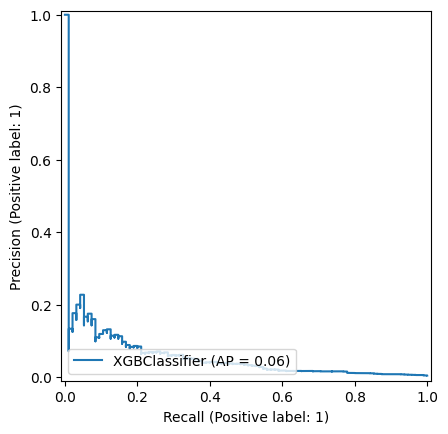

In [3]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_5year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types
continuous_features = feature_sets.minimal_features_rfecv_5year_tte[
    minimal_features_rfecv_5year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_5year_tte[
    minimal_features_rfecv_5year_tte['coding_type'] == 'binary']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features)
    ],
    remainder='passthrough' )

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
feature_names = np.concatenate([cont_feature_names, binary_feature_names])

# Initialize and train XGBoost with clinical constraints
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,  # Shallower trees for interpretability
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    min_child_weight=10,  # Require more samples per leaf
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'#,
    #verbosity=0
)



# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    verbose=False
)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance (more reliable)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_preprocessed)

# Get mean absolute SHAP values for each feature
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': abs(shap_values.values).mean(axis=0),
    'Importance (shap)': shap_values.values.mean(axis=0)})
print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.title('Precision-Recall Curve')
plt.show()

In [8]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_5year_tte['feature']]

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    colsample_bytree = 0.5887,
    gamma = 0.0001544,
    reg_lambda = 0.01208,
    learning_rate = 0.007159,
    max_bin = 783,
    max_depth = 6,
    min_child_weight = 5.067,
    n_estimators = 261,
    subsample = 0.7823,
    random_state=1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),  # For class imbalance
    eval_metric='logloss')

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]  # Probability for class 1

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)


# Feature importance (XGBoost provides feature importance scores)
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_5year_tte['feature'],
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (XGBoost):")
    print(feature_importance)



XGBoost Results:
AUROC: 0.8309
Accuracy: 0.8880
Precision (PPV): 0.0205
Recall (Sensitivity): 0.5263
Specificity: 0.8896
NPV: 0.9977
F1 Score: 0.0394

Confusion Matrix 
TN FP 
FN TP:
[[19293  2394]
 [   45    50]]

Feature Importance (XGBoost):
                                Feature  Importance
0                    IOPg pre-treatment    0.217214
9                             Ethnicity    0.177187
6                  Polygenic risk score    0.139449
7             Age at initial assesement    0.100595
2                    Corneal hysteresis    0.079861
65                            Metformin    0.067221
50  Irritable bowel syndrome (baseline)    0.063903
67                         Beta blocker    0.060816
68              Calcium channel blocker    0.049587
78            Vitamin C supplementation    0.044169


<br>

### run 5 year tte model on minimal feature set (after class balance via smote)

AUROC: 0.7651\
Precision: 0.0294\
Recall: 0.2979\
F1 Score: 0.0535

In [70]:
print("\nClass Distribution (pre SMOTE):")
print(pd.Series(y_train).value_counts(normalize=True))

# Identify feature types
continuous_features = feature_sets.minimal_features_rfecv_5year_tte[
    feature_sets.minimal_features_rfecv_5year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_5year_tte[
    feature_sets.minimal_features_rfecv_5year_tte['coding_type'] == 'binary']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features)
    ],
    remainder='passthrough'
)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train[feature_sets.minimal_features_rfecv_5year_tte['feature']])
X_test_preprocessed = preprocessor.transform(X_test[feature_sets.minimal_features_rfecv_5year_tte['feature']])

# Get feature names after preprocessing
feature_names = continuous_features + list(preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features))

# 2. SMOTE Resampling
smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
print("\nClass Distribution (post SMOTE):")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# 3. Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    min_child_weight=10,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr',
    verbosity=0
)

# Cross-validate to find optimal threshold
cv = StratifiedKFold(n_splits=5)
# Change this line in your code:
y_proba = cross_val_predict(xgb_model, X_train_resampled, y_train_resampled, 
                          cv=cv, method='predict_proba', n_jobs=1)[:,1]  # Set n_jobs=1

precision, recall, thresholds = precision_recall_curve(y_train_resampled, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Train final model
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:,1]
y_pred_opt = (y_pred_proba >= optimal_threshold).astype(int)

# Print metrics
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_opt):.4f}")

print("\nConfusion Matrix (TN, FP | FN, TP):")
print(confusion_matrix(y_test, y_pred_opt))

print(f"\nAverage Precision Score: {average_precision_score(y_test, y_pred_proba):.3f}")
print(f"Optimal Threshold: {optimal_threshold:.3f} (maximizes F1)")

# Feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Analysis:")
print(importance_df.to_string(index=False))

# SHAP values for clinical interpretation
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)

print("\nSHAP Feature Importance:")
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean|SHAP|': np.abs(shap_values).mean(axis=0)
}).sort_values('Mean|SHAP|', ascending=False)
print(shap_df.to_string(index=False))


Class Distribution (pre SMOTE):
tte_5year
0    0.995644
1    0.004356
Name: proportion, dtype: float64

Class Distribution (post SMOTE):
tte_5year
0    0.909098
1    0.090902
Name: proportion, dtype: float64

XGBoost Results:
AUROC: 0.7651
Precision: 0.0294
Recall: 0.2979
F1 Score: 0.0535

Confusion Matrix (TN, FP | FN, TP):
[[10381   462]
 [   33    14]]

Average Precision Score: 0.035
Optimal Threshold: 0.978 (maximizes F1)

Feature Importance Analysis:
                                     Feature  Importance
                          IOPg pre-treatment    0.144127
                               Ethnicity_1.0    0.140774
                        Polygenic risk score    0.124222
                   Age at initial assesement    0.119109
     Irritable bowel syndrome (baseline)_1.0    0.086429
            Diabetes mellitus (baseline)_1.0    0.077622
                          Corneal hysteresis    0.069729
                            Beta blocker_1.0    0.059476
     Corneal hysteresis in

<br>

<br>

## 10 year tte

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_10year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_10year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_10year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_10year_tte.pkl')
minimal_features_rfecv_10year_tte = feature_sets.minimal_features_rfecv_10year_tte

<br>

### run 10 year tte model on minimal feature set (before class balance)

AUROC: 0.8299\
Precision: 0.0354\
Recall: 0.7769\
F1 Score: 0.0677

In [8]:
# old model
# Make sure we only use the selected features
minimal_features_rfecv_10year_tte = feature_sets.OD_features

X_train_selected = X_train[minimal_features_rfecv_10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_10year_tte['feature']]



# Initialize and train LightGBM model
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)

# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(lgb_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_10year_tte['feature'],
        'Coefficient': lgb_model.coef_[0],
        'Abs Coefficient': abs(lgb_model.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    pd.set_option('display.width', 1000)
    
    print("\nFeature Importance Analysis:")
    print(feature_importance.to_string(index=False, justify='left'))    

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 188, number of negative: 86744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2345
[LightGBM] [Info] Number of data points in the train set: 86932, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

Logistic Regression Results:
AUROC: 0.8366
Precision: 0.0457
Recall: 0.1875
F1 Score: 0.0735

Confusion Matrix 
TN FP 
FN TP:
[[21499   188]
 [   39     9]]


In [13]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_10year_tte['feature']]

# Initialize and train LightGBM model with optimized hyperparameters
lgb_model = lgb.LGBMClassifier(
    bagging_fraction=0.7971,
    feature_fraction=0.9,
    lambda_l2=0.028,      
    learning_rate=0.005169,
    max_bin=157,
    max_depth=5,
    min_data_in_leaf=2107,   
    min_sum_hessian_in_leaf=3.66,  
    n_estimators=454,
    num_leaves=117,
    random_state=1,
    class_weight='balanced')


# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1] 


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLightGBM Results (Optimized Hyperparameters):")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)



# Feature importance (LightGBM provides feature importance scores)
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_10year_tte['feature'],
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (LightGBM):")
    print(feature_importance)



LightGBM Results (Optimized Hyperparameters):
AUROC: 0.8420
Accuracy: 0.8573
Precision (PPV): 0.0100
Recall (Sensitivity): 0.6458
Specificity: 0.8578
NPV: 0.9991
F1 Score: 0.0196

Confusion Matrix 
TN FP 
FN TP:
[[18603  3084]
 [   17    31]]

Feature Importance (LightGBM):
                                    Feature  Importance
0                        IOPg pre-treatment        1752
6                      Polygenic risk score        1321
2                        Corneal hysteresis        1008
3   Corneal hysteresis inter-eye difference         691
12               Townsend deprivation index         689
1   IOPg pre-treatment inter-eye difference         650
5                      Spherical equivalent         382
10                           PM2.5 exposure         380


<br>

### run 10 year tte model on minimal feature set (after class balance via smote)

AUROC: 0.8299\
Precision: 0.1559\
Recall: 0.2397\
F1 Score: 0.1889

In [90]:
# 1. Check class distribution
print("\nClass Distribution (pre smote):")
print(pd.Series(y_train).value_counts(normalize=True))

# 2. Stratified Cross-Validation with SMOTE
pipeline = make_pipeline(
    SMOTE(random_state=42, sampling_strategy=0.1),  # Balance to 10% positive
    LogisticRegression(
        class_weight='balanced',
        penalty='l2',
        C=0.1,
        solver='lbfgs',
        max_iter=1000,
        random_state=42
    )
)

smote = SMOTE(random_state=42, sampling_strategy=0.1)  # Balance to 10% positive
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("\nClass Distribution (post smote):")
print(pd.Series(y_train_resampled).value_counts(normalize=True))

# Get probabilistic predictions via cross-validation
cv = StratifiedKFold(n_splits=5)
y_proba = cross_val_predict(pipeline, X_train_selected, y_train, 
                           cv=cv, method='predict_proba')[:,1]

# 3. Find Optimal Threshold
precision, recall, thresholds = precision_recall_curve(y_train, y_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# 4. Train Final Model
pipeline.fit(X_train_selected, y_train)
y_pred_opt = (pipeline.predict_proba(X_test_selected)[:,1] >= optimal_threshold).astype(int)



# Print all requested metrics
print("\n\nLogistic Regression Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_opt):.4f}")


# 5. Enhanced Evaluation
#print("\nOptimized Classification Report:")
#print(classification_report(y_test, y_pred_opt))

# Print confusion matrix
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(confusion_matrix(y_test, y_pred_opt))

# Print precision-recall metrics
ap_score = average_precision_score(y_test, pipeline.predict_proba(X_test_selected)[:,1])
print(f"\nAverage Precision Score: {ap_score:.3f}")
print(f"Optimal Threshold: {optimal_threshold:.3f} (maximizes F1)")

# 6. Feature Importance Analysis
logreg_model = pipeline.named_steps['logisticregression']
feature_importance = pd.DataFrame({
    'Feature': feature_sets.minimal_features_rfecv_10year_tte['feature'],
    'Coefficient': logreg_model.coef_[0],
    'Abs_Coefficient': abs(logreg_model.coef_[0]),
    #'Odds_Ratio': np.exp(logreg_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\n\nFeature Importance Analysis:")
print(feature_importance.to_string(index=False))


Class Distribution (pre smote):
tte_10year
0    0.988934
1    0.011066
Name: proportion, dtype: float64

Class Distribution (post smote):
tte_10year
0    0.909098
1    0.090902
Name: proportion, dtype: float64


Logistic Regression Results:
AUROC: 0.8299
Precision: 0.1559
Recall: 0.2397
F1 Score: 0.1889


Confusion Matrix (TN, FP | FN, TP):
[[10686   157]
 [   92    29]]

Average Precision Score: 0.114
Optimal Threshold: 0.862 (maximizes F1)


Feature Importance Analysis:
                                             Feature  Coefficient  Abs_Coefficient
                                  IOPg pre-treatment    12.984161        12.984161
                                  Corneal hysteresis    -4.998675         4.998675
                                Polygenic risk score     4.080289         4.080289
             Corneal hysteresis inter-eye difference    -3.310190         3.310190
                           Age at initial assesement     3.091330         3.091330
                        

<br>

<br>

---

# Age and sex matched models


## 3 year tte

Logistic Regression Results:\
AUROC: 0.8630\
Accuracy: 0.7654\
Precision (PPV): 0.2566\
Recall (Sensitivity): 0.8125\
Specificity: 0.7606\
NPV: 0.9755\
F1 Score: 0.3900

In [306]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_matched3year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_matched3year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_matched3year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_matched3year_tte.pkl')
minimal_features_rfecv_matched3year_tte = feature_sets.minimal_features_rfecv_matched3year_tte

<br>

### run 3 year (matched) tte model on minimal feature set 



XGB Results:
AUROC: 0.8272
Precision: 0.4407
Recall: 0.5417
F1 Score: 0.4860
Optimal Threshold: 0.6836

Confusion Matrix 
TN FP 
FN TP
[[439  33]
 [ 22  26]]

SHAP Feature Importance:
                                Feature  Abs Importance (shap)  Importance (shap)
                     IOPg pre-treatment               1.251998          -0.761591
IOPg pre-treatment inter-eye difference               0.350079          -0.238178
                     Corneal hysteresis               0.291653          -0.195166
Corneal hysteresis inter-eye difference               0.314048          -0.120730
                   Spherical equivalent               0.279129          -0.177478
                   Polygenic risk score               0.724397          -0.414328
                          Ethnicity_1.0               0.279385          -0.070825


AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

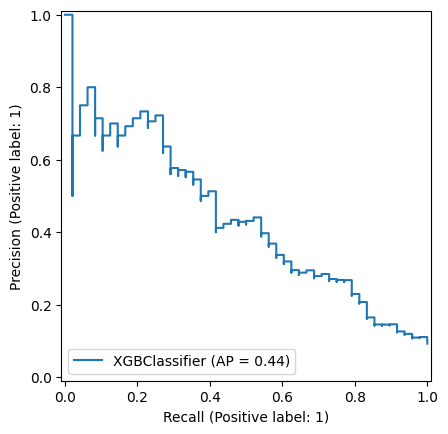

In [209]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_matched3year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types
continuous_features = feature_sets.minimal_features_rfecv_matched3year_tte[
    minimal_features_rfecv_matched3year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_matched3year_tte[
    minimal_features_rfecv_matched3year_tte['coding_type'] == 'binary']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features)
    ],
    remainder='passthrough' )

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
feature_names = np.concatenate([cont_feature_names, binary_feature_names])

# Initialize and train XGBoost with clinical constraints
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,  # Shallower trees for interpretability
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    min_child_weight=10,  # Require more samples per leaf
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'#,
    #verbosity=0
)



# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    verbose=False
)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nXGB Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance (more reliable)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_preprocessed)

# Get mean absolute SHAP values for each feature
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': abs(shap_values.values).mean(axis=0),
    'Importance (shap)': shap_values.values.mean(axis=0)})
print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.pyplot.title('Precision-Recall Curve')



Logistic Regression Results:
AUROC: 0.8603
Accuracy: 0.7673
Precision (PPV): 0.2517
Recall (Sensitivity): 0.7708
Specificity: 0.7669
NPV: 0.9705
F1 Score: 0.3795

Confusion Matrix 
TN FP 
FN TP:
[[362 110]
 [ 11  37]]

Feature Importance (Coefficients):
                                   Feature  Importance  Abs Coefficient
0                       IOPg pre-treatment   13.062538        13.062538
3  Corneal hysteresis inter-eye difference   -6.431243         6.431243
6                     Polygenic risk score    4.292851         4.292851
2                       Corneal hysteresis   -4.149614         4.149614
5                     Spherical equivalent   -2.076784         2.076784
9                                Ethnicity   -1.644270         1.644270
1  IOPg pre-treatment inter-eye difference    1.282499         1.282499


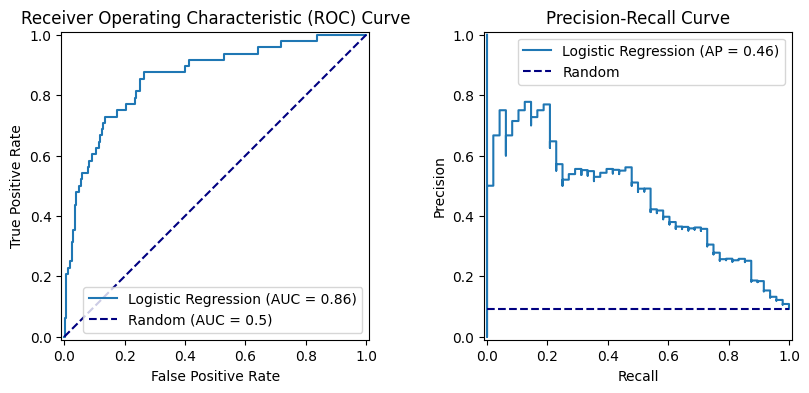

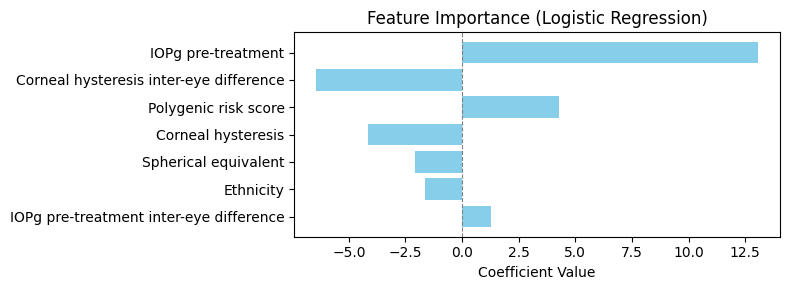

In [307]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_matched3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_matched3year_tte['feature']]


logreg = SGDClassifier(
    loss='log_loss',           
    penalty='l2',
    alpha=1.536e-6, # optimal hyperparameter 
    eta0 = 0.09975, # optimal hyperparameter 
    max_iter=1000,
    random_state=3,
    class_weight='balanced',
    tol=1e-3,                  
    learning_rate='adaptive', # optimal hyperparameter              
    fit_intercept=True,
    n_iter_no_change=5)


# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_matched3year_tte['feature'],
        'Importance': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # You'll need to calculate this
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (AUC = 0.5)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name='Logistic Regression')
pr_display.plot(ax=ax2)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='Random')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="best")


plt.figure(figsize=(8, 3))
# Plot the coefficients, sorted by absolute value
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Logistic Regression)')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8) # Add a vertical line at zero
plt.gca().invert_yaxis() # Invert y-axis to have the most important feature on top
plt.tight_layout()
plt.show()

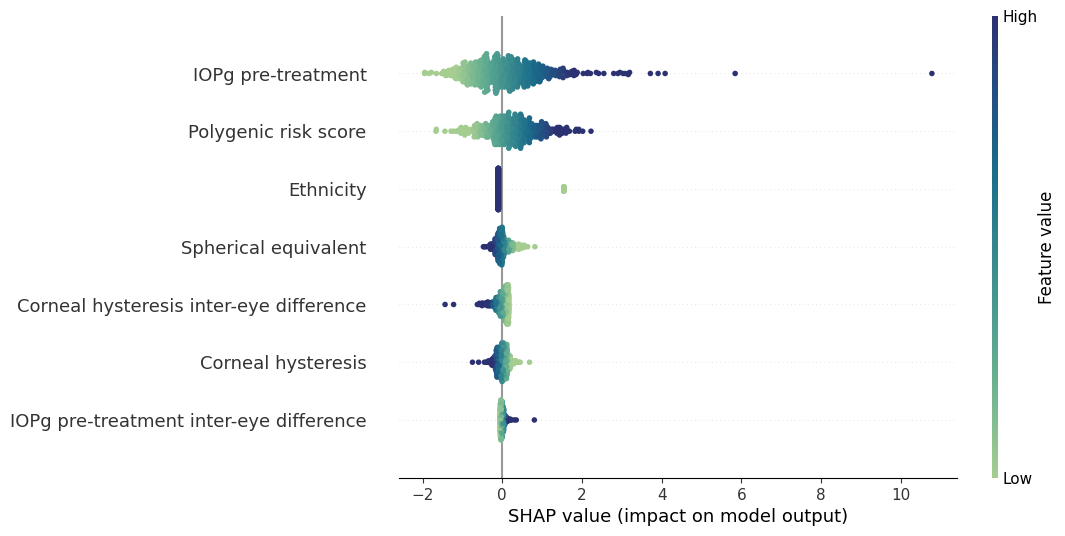

In [19]:
# shap feature importance (not very informative)

import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the JS visualization code (needed for plots)
shap.initjs()

# Create a SHAP explainer for your model
explainer = shap.Explainer(logreg, X_train_selected)
shap_values = explainer(X_test_selected)

# Create the beeswarm plot with your specified style
ax = shap.plots.beeswarm(shap_values, 
                         max_display=21, 
                         order=shap_values.abs.mean(0), 
                         color=sns.color_palette('crest', as_cmap=True), 
                         plot_size=(9, 6), 
                         show=False)



# Save the figure with high resolution
plt.savefig(fname='./interpretation/feature_importance_shap.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.show()

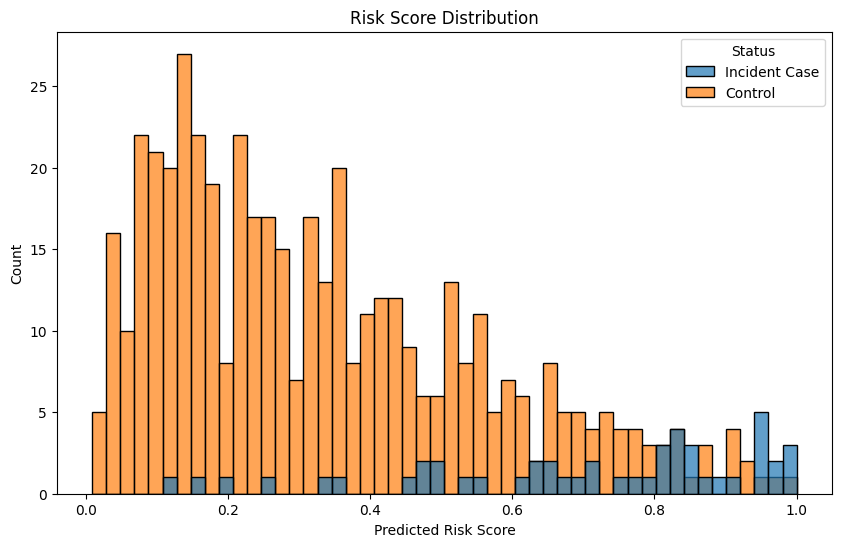

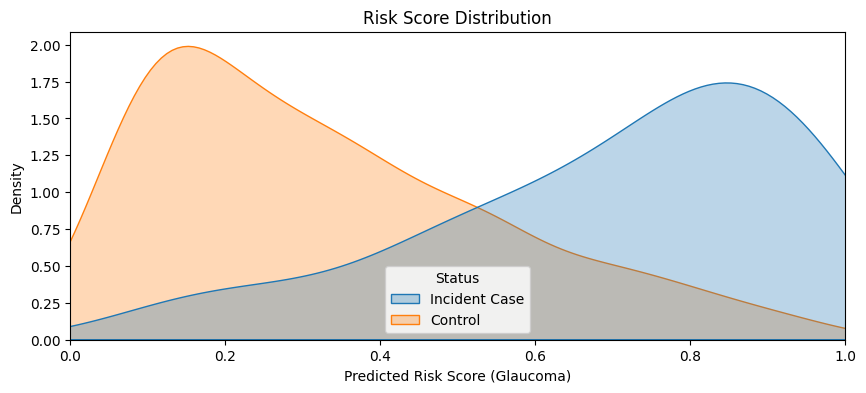

In [415]:
# risk score histogram for cases and controls
y_pred_proba = logreg.predict_proba(X_test_selected)  
risk_scores = y_pred_proba[:, 1]  


plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'actual_case': y_test })

plot_data['Status'] = plot_data['actual_case'].map({1: 'Incident Case', 0: 'Control'})


# histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, x='risk_score', hue='Status', bins=50, alpha=0.7, multiple='layer')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution')
plt.show()

plt.figure(figsize=(10, 4))
sns.kdeplot(data=plot_data, x='risk_score', hue='Status', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
plt.xlabel('Predicted Risk Score (Glaucoma)')
plt.title('Risk Score Distribution')
plt.xlim(0, 1)
plt.show()


MS Group Counts:
  Glaucoma + MS: 1
  Glaucoma + No MS: 235
  No Glaucoma + MS: 5
  No Glaucoma + No MS: 2355
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.7119
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.0142


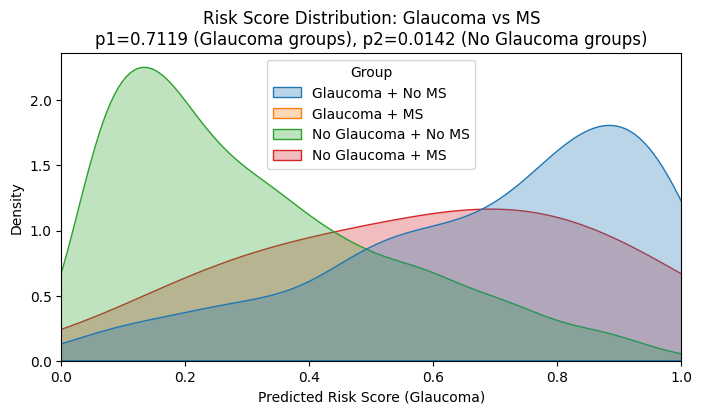


ALZD Group Counts:
  Glaucoma + ALZD: 1
  Glaucoma + No ALZD: 235
  No Glaucoma + ALZD: 10
  No Glaucoma + No ALZD: 2350
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.5932
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.1805


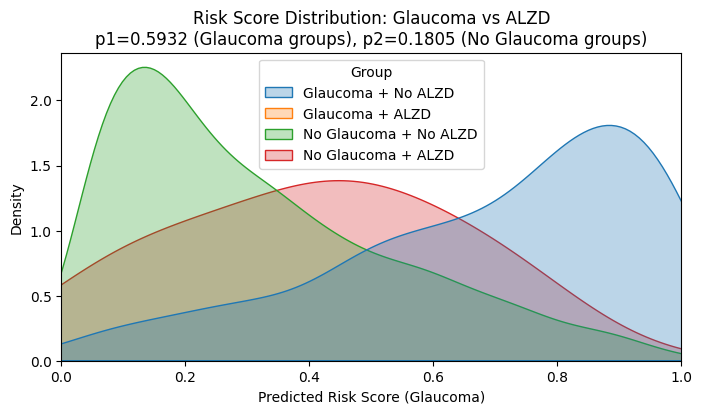


PD Group Counts:
  Glaucoma + No PD: 232
  Glaucoma + PD: 4
  No Glaucoma + No PD: 2343
  No Glaucoma + PD: 17
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.7620
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.3391


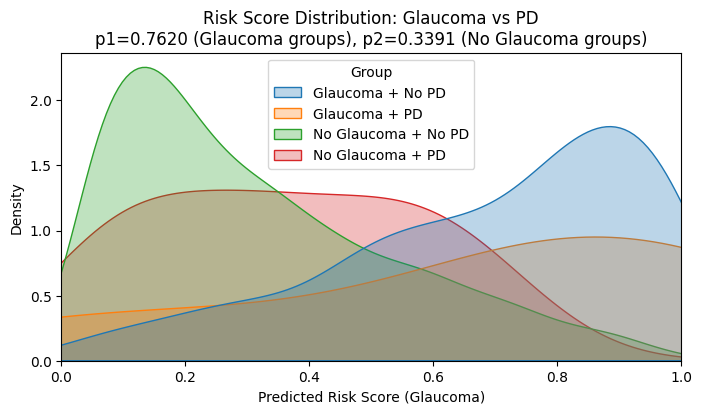


APOE4 Group Counts:
  Glaucoma + APOE4: 6
  Glaucoma + No APOE4: 227
  No Glaucoma + APOE4: 45
  No Glaucoma + No APOE4: 2230
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.5957
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.4271


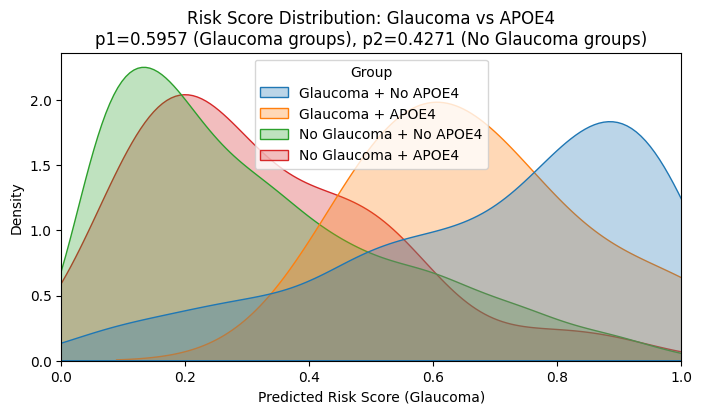


Cataracts Group Counts:
  Glaucoma + Cataracts: 68
  Glaucoma + No Cataracts: 168
  No Glaucoma + Cataracts: 427
  No Glaucoma + No Cataracts: 1933
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.7244
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.2613


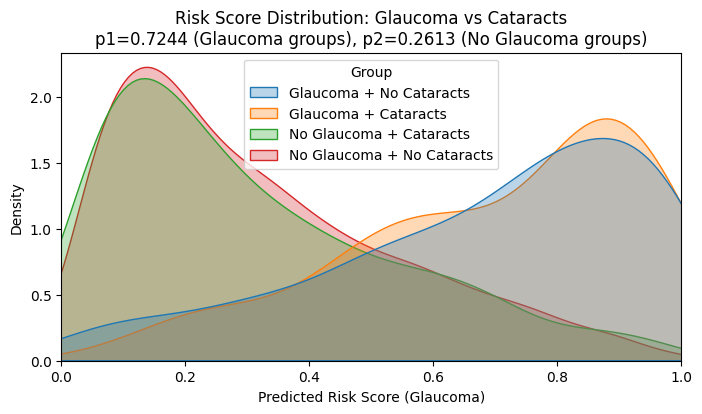


AMD Group Counts:
  Glaucoma + AMD: 15
  Glaucoma + No AMD: 221
  No Glaucoma + AMD: 81
  No Glaucoma + No AMD: 2279
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.1763
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.5367


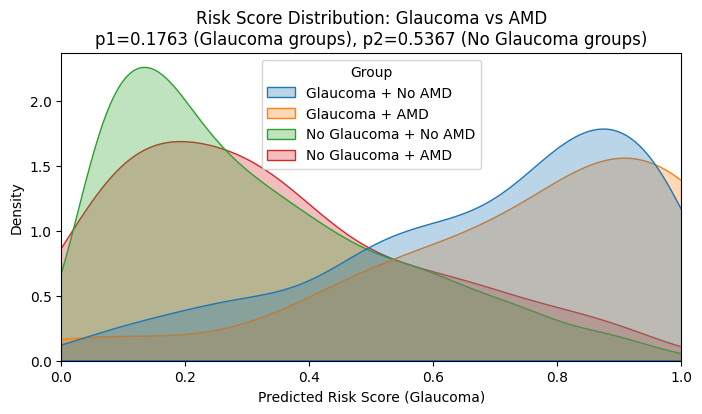


DR Group Counts:
  Glaucoma + DR: 13
  Glaucoma + No DR: 223
  No Glaucoma + DR: 64
  No Glaucoma + No DR: 2296
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.0905
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.3654


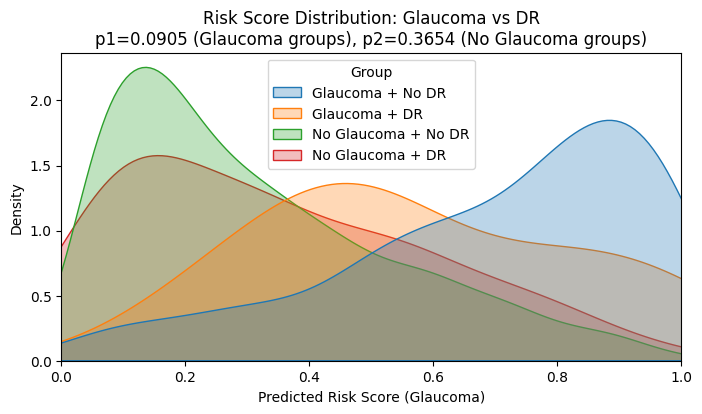


T2D Group Counts:
  Glaucoma + No T2D: 200
  Glaucoma + T2D: 36
  No Glaucoma + No T2D: 2113
  No Glaucoma + T2D: 247
  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = 0.7333
  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = 0.1848


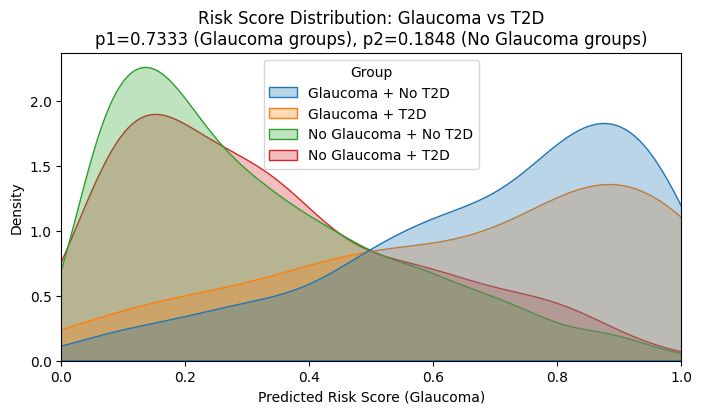

In [417]:
# all histograms with the other diseases against glaucoma risk
glaucoma_diseases = pd.read_table('IH_data.txt').rename(columns={'Participant_ID': 'ID'})
matched = pd.read_csv('../matched_3year_tte.csv').rename(columns={'f.eid': 'ID'})[['ID', 'tte_3year_80_20_split']]
glaucoma_diseases = pd.merge(glaucoma_diseases, matched, on='ID')

# glaucoma risk score against disease prevalence
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])
risk_scores = logreg.predict_proba(X_full)[:, 1]

# Create lists/arrays instead of pandas Series to avoid index issues
plot_data = pd.DataFrame({
    'ID': glaucoma_diseases['ID'],
    'risk_score': risk_scores,
    'MS': glaucoma_diseases['MS'].map({'Control': 'No MS', 'MS':'MS'}).values,
    'ALZD': glaucoma_diseases['ALZD'].map({'Control': 'No ALZD', 'ALZD':'ALZD'}).values,
    'PD': glaucoma_diseases['PD'].map({'Control': 'No PD', 'PD':'PD'}).values,
    'APOE4': glaucoma_diseases['APOE4'].map({'Control': 'No APOE4', 'APOE4':'APOE4'}).values,
    'Cataracts': glaucoma_diseases['cat_prevalence'].map({0: 'No Cataracts', 1: 'Cataracts'}).values,
    'AMD': glaucoma_diseases['AMD_prevalence'].map({0: 'No AMD', 1: 'AMD'}).values,
    'DR': glaucoma_diseases['DR_prevalence'].map({0: 'No DR', 1: 'DR'}).values,
    'T2D': glaucoma_diseases['prevalent_T2D'].map({0: 'No T2D', 1: 'T2D'}).values,
    'Glaucoma': y_full.map({0: 'No Glaucoma', 1: 'Glaucoma'}).values
})

# for the diagnosis source histogram
cases_only = plot_data.loc[plot_data['Glaucoma'] == 'Glaucoma']

for disease in plot_data.drop(columns=['ID', 'risk_score', 'Glaucoma']):
    plt.figure(figsize=(8, 4))
    plot_data['Group'] = plot_data['Glaucoma'] + ' + ' + plot_data[disease]

    print(f"\n{disease} Group Counts:")
    group_counts = plot_data['Group'].value_counts().sort_index()
    for group, count in group_counts.items():
        print(f"  {group}: {count}")
    
    # Perform Wilcoxon tests
    # Test 1: Glaucoma + Disease vs Glaucoma + No Disease
    glaucoma_disease = plot_data[(plot_data['Glaucoma'] == 'Glaucoma') & (plot_data[disease].str.contains('No ') == False)]['risk_score']
    glaucoma_no_disease = plot_data[(plot_data['Glaucoma'] == 'Glaucoma') & (plot_data[disease].str.contains('No '))]['risk_score']
    
    # Test 2: No Glaucoma + Disease vs No Glaucoma + No Disease  
    no_glaucoma_disease = plot_data[(plot_data['Glaucoma'] == 'No Glaucoma') & (plot_data[disease].str.contains('No ') == False)]['risk_score']
    no_glaucoma_no_disease = plot_data[(plot_data['Glaucoma'] == 'No Glaucoma') & (plot_data[disease].str.contains('No '))]['risk_score']
    
    # Only perform tests if we have enough samples in both groups
    if len(glaucoma_disease) > 0 and len(glaucoma_no_disease) > 0:
        stat1, p1 = mannwhitneyu(glaucoma_disease, glaucoma_no_disease, alternative='two-sided')
        print(f"  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): p = {p1:.4f}")
    else:
        p1 = np.nan
        print(f"  Wilcoxon test (Glaucoma + Disease vs Glaucoma + No Disease): insufficient samples")
    
    if len(no_glaucoma_disease) > 0 and len(no_glaucoma_no_disease) > 0:
        stat2, p2 = mannwhitneyu(no_glaucoma_disease, no_glaucoma_no_disease, alternative='two-sided')
        print(f"  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): p = {p2:.4f}")
    else:
        p2 = np.nan
        print(f"  Wilcoxon test (No Glaucoma + Disease vs No Glaucoma + No Disease): insufficient samples")
    
    # Create the plot
    sns.kdeplot(data=plot_data, x='risk_score', hue='Group', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
    plt.xlabel('Predicted Risk Score (Glaucoma)')
    plt.title(f'Risk Score Distribution: Glaucoma vs {disease}\n'
              f'p1={p1:.4f} (Glaucoma groups), p2={p2:.4f} (No Glaucoma groups)')
    plt.xlim(0, 1)
    plt.show()

Neurodegenerative disease group counts:
  Glaucoma + AZHD/PD/MS: 6
  Glaucoma + No AZHD/PD/MS: 230
  No Glaucoma + AZHD/PD/MS: 32
  No Glaucoma + No AZHD/PD/MS: 2328
  Wilcoxon test (Glaucoma + Neurodegenerative vs Glaucoma + No Neurodegenerative): p = 0.8155
  Wilcoxon test (No Glaucoma + Neurodegenerative vs No Glaucoma + No Neurodegenerative): p = 0.0167


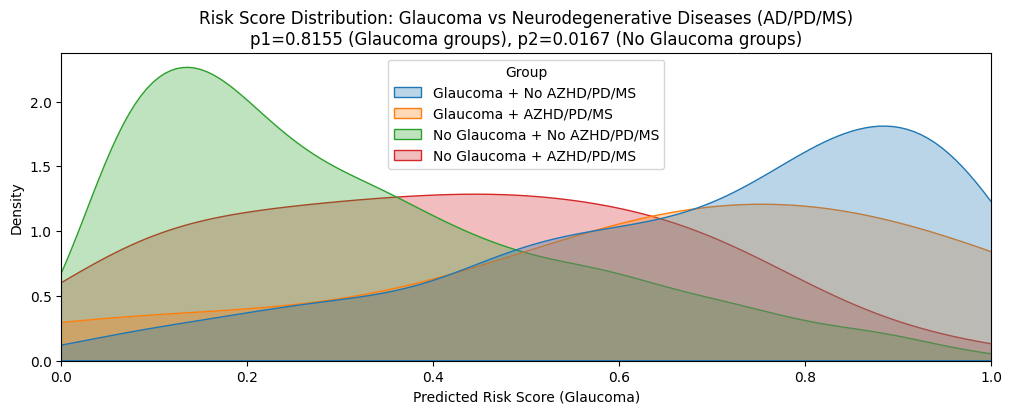

In [418]:
# histogram with glaucoma risk against all neurodegenerative diseases
plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'Glaucoma': y_full.map({0: 'No Glaucoma', 1: 'Glaucoma'}).values
})

# neurodegenerative disease group (ANY of ALZD, PD, or MS)
has_neurodegenerative = (
    (glaucoma_diseases['ALZD'] == 'ALZD') | 
    (glaucoma_diseases['PD'] == 'PD') | 
    (glaucoma_diseases['MS'] == 'MS')
)

plot_data['Neurodegenerative'] = np.where(
    has_neurodegenerative, 
    'AZHD/PD/MS', 
    'No AZHD/PD/MS'
)

# Create the four combined groups
plot_data['Group'] = plot_data['Glaucoma'] + ' + ' + plot_data['Neurodegenerative']

print("Neurodegenerative disease group counts:")
group_counts = plot_data['Group'].value_counts().sort_index()
for group, count in group_counts.items():
    print(f"  {group}: {count}")

# Perform Wilcoxon tests
# Test 1: Glaucoma + Neurodegenerative vs Glaucoma + No Neurodegenerative
glaucoma_neuro = plot_data[(plot_data['Glaucoma'] == 'Glaucoma') & (plot_data['Neurodegenerative'] == 'AZHD/PD/MS')]['risk_score']
glaucoma_no_neuro = plot_data[(plot_data['Glaucoma'] == 'Glaucoma') & (plot_data['Neurodegenerative'] == 'No AZHD/PD/MS')]['risk_score']

# Test 2: No Glaucoma + Neurodegenerative vs No Glaucoma + No Neurodegenerative  
no_glaucoma_neuro = plot_data[(plot_data['Glaucoma'] == 'No Glaucoma') & (plot_data['Neurodegenerative'] == 'AZHD/PD/MS')]['risk_score']
no_glaucoma_no_neuro = plot_data[(plot_data['Glaucoma'] == 'No Glaucoma') & (plot_data['Neurodegenerative'] == 'No AZHD/PD/MS')]['risk_score']

# Only perform tests if we have enough samples in both groups
if len(glaucoma_neuro) > 0 and len(glaucoma_no_neuro) > 0:
    stat1, p1 = mannwhitneyu(glaucoma_neuro, glaucoma_no_neuro, alternative='two-sided')
    print(f"  Wilcoxon test (Glaucoma + Neurodegenerative vs Glaucoma + No Neurodegenerative): p = {p1:.4f}")
else:
    p1 = np.nan
    print(f"  Wilcoxon test (Glaucoma + Neurodegenerative vs Glaucoma + No Neurodegenerative): insufficient samples")

if len(no_glaucoma_neuro) > 0 and len(no_glaucoma_no_neuro) > 0:
    stat2, p2 = mannwhitneyu(no_glaucoma_neuro, no_glaucoma_no_neuro, alternative='two-sided')
    print(f"  Wilcoxon test (No Glaucoma + Neurodegenerative vs No Glaucoma + No Neurodegenerative): p = {p2:.4f}")
else:
    p2 = np.nan
    print(f"  Wilcoxon test (No Glaucoma + Neurodegenerative vs No Glaucoma + No Neurodegenerative): insufficient samples")

# Create the plot
plt.figure(figsize=(12, 4))
sns.kdeplot(data=plot_data, x='risk_score', hue='Group', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
plt.xlabel('Predicted Risk Score (Glaucoma)')
plt.title(f'Risk Score Distribution: Glaucoma vs Neurodegenerative Diseases (AD/PD/MS)\n'
          f'p1={p1:.4f} (Glaucoma groups), p2={p2:.4f} (No Glaucoma groups)')
plt.xlim(0, 1)
plt.show()

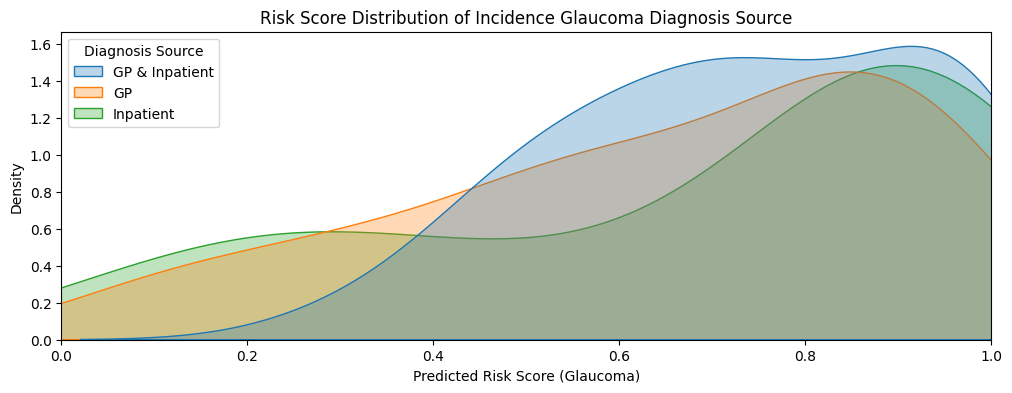

In [412]:
# histogram of diagnosis source
cases = pd.read_csv('../incidence_glaucoma.csv').rename(columns={'f.eid': 'ID'})[['ID', 'diagnosis_source']] #500 000

cases_diagnosis_source = pd.merge(cases, cases_only, on = 'ID')[['risk_score', 'diagnosis_source']]
cases_diagnosis_source['Diagnosis Source'] = cases_diagnosis_source['diagnosis_source'].replace({
    'Self-report & Inpatient': 'Inpatient',
    'Self-report & GP': 'GP' })

plt.figure(figsize=(12, 4))
sns.kdeplot(data=cases_diagnosis_source, x='risk_score', hue='Diagnosis Source', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
plt.xlabel('Predicted Risk Score (Glaucoma)')
plt.title('Risk Score Distribution of Incidence Glaucoma Diagnosis Source')
plt.xlim(0, 1)
plt.show()

<br>

<br>

## 5 year tte

XGBoost Results:\
AUROC: 0.8011\
Accuracy: 0.7661\
Precision (PPV): 0.2330\
Recall (Sensitivity): 0.6842\
Specificity: 0.7743\
NPV: 0.9607\
F1 Score: 0.3476

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_matched5year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_matched5year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_matched5year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_matched5year_tte.pkl')
minimal_features_rfecv_matched5year_tte = feature_sets.minimal_features_rfecv_matched5year_tte

<br>

### run 5 year (matched) tte model on minimal feature set


XGBoost Results:
AUROC: 0.7818
Precision: 0.3497
Recall: 0.5263
F1 Score: 0.4202
Optimal Threshold: 0.6690

Confusion Matrix 
TN FP 
FN TP:
[[855  93]
 [ 45  50]]

SHAP Feature Importance:
                                     Feature  Abs Importance (shap)  Importance (shap)
                          IOPg pre-treatment               0.877682          -0.546940
                        Polygenic risk score               0.838081          -0.486693
                               Ethnicity_1.0               0.254544          -0.078600
Helicobacter pylori infection (baseline)_1.0               0.000000           0.000000


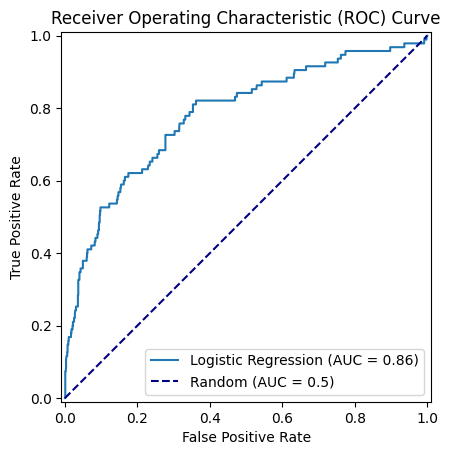

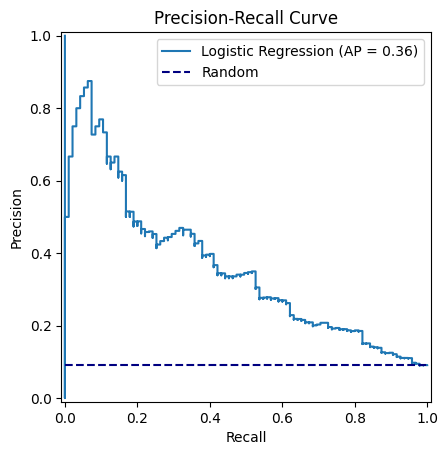

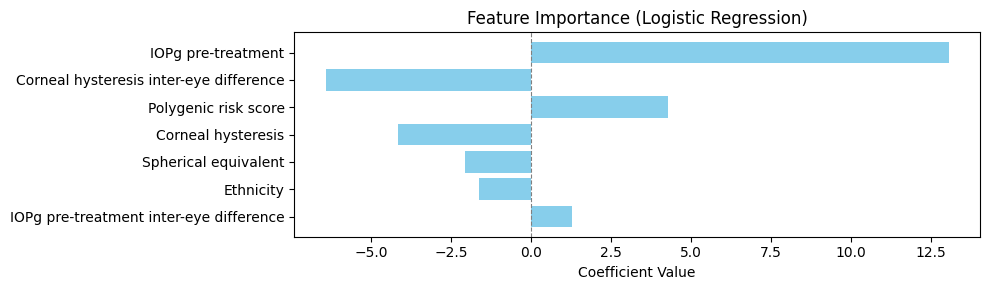

In [41]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_matched5year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types
continuous_features = feature_sets.minimal_features_rfecv_matched5year_tte[
    minimal_features_rfecv_matched5year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_matched5year_tte[
    minimal_features_rfecv_matched5year_tte['coding_type'] == 'binary']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features)
    ],
    remainder='passthrough' )

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
feature_names = np.concatenate([cont_feature_names, binary_feature_names])

# Initialize and train XGBoost with clinical constraints
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,  # Shallower trees for interpretability
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    min_child_weight=10,  # Require more samples per leaf
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'#,
    #verbosity=0
)



# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    verbose=False
)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance (more reliable)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_preprocessed)

# Get mean absolute SHAP values for each feature
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': abs(shap_values.values).mean(axis=0),
    'Importance (shap)': shap_values.values.mean(axis=0)})
print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.pyplot.title('Precision-Recall Curve')

In [3]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_matched5year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types 
continuous_features = feature_sets.minimal_features_rfecv_matched5year_tte[
    feature_sets.minimal_features_rfecv_matched5year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_matched5year_tte[
    feature_sets.minimal_features_rfecv_matched5year_tte['coding_type'] == 'binary']['feature'].tolist()
ordinal_features = feature_sets.minimal_features_rfecv_matched5year_tte[
    feature_sets.minimal_features_rfecv_matched5year_tte['coding_type'] == 'ordinal']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features),
        ('ordinal', 'passthrough', ordinal_features)  
    ])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
ordinal_feature_names = ordinal_features 
feature_names = np.concatenate([cont_feature_names, binary_feature_names, ordinal_feature_names])

# Initialize and train LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=10,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    verbose=-1
)

# Fit with early stopping
lgb_model.fit(
    X_train_preprocessed, 
    y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    eval_metric='aucpr',  # Must specify eval_metric here
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)

# Make predictions
y_pred_proba = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nLGBM Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix (TN, FP | FN, TP):")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance with correct parameters
explainer = shap.TreeExplainer(
    lgb_model,
    feature_perturbation='tree_path_dependent',
    model_output='raw'  # Changed from 'probability' to 'raw'
)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_preprocessed)

# For binary classification, SHAP returns a list of arrays:
# [shap_values_class_0, shap_values_class_1]
# We typically use the positive class (class 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Get values for positive class

# Create DataFrame with feature importance
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': np.abs(shap_values).mean(axis=0),
    'Importance (shap)': shap_values.mean(axis=0)
})

print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.pyplot.title('Precision-Recall Curve')


/home/eake191/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/eake191/.pyenv/versions/3.13.2/lib/python3.13/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')



LGBM Results:
AUROC: 0.6851
Precision: 0.2216
Recall: 0.3895
F1 Score: 0.2824
Optimal Threshold: 0.1265

Confusion Matrix (TN, FP | FN, TP):
[[818 130]
 [ 58  37]]

SHAP Feature Importance:
                                     Feature  Abs Importance (shap)  Importance (shap)
                          IOPg pre-treatment               0.000000           0.000000
                        Polygenic risk score               0.106582          -0.004007
                               Ethnicity_1.0               0.023663           0.000765
Helicobacter pylori infection (baseline)_1.0               0.000000           0.000000


NameError: name 'xgb_model' is not defined


XGBoost Results:
AUROC: 0.8011
Accuracy: 0.7661
Precision (PPV): 0.2330
Recall (Sensitivity): 0.6842
Specificity: 0.7743
NPV: 0.9607
F1 Score: 0.3476

Confusion Matrix 
TN FP 
FN TP:
[[734 214]
 [ 30  65]]

Feature Importance (XGBoost):
                                     Feature  Importance
0                         IOPg pre-treatment    0.377297
9                                  Ethnicity    0.305676
6                       Polygenic risk score    0.259505
49  Helicobacter pylori infection (baseline)    0.057522


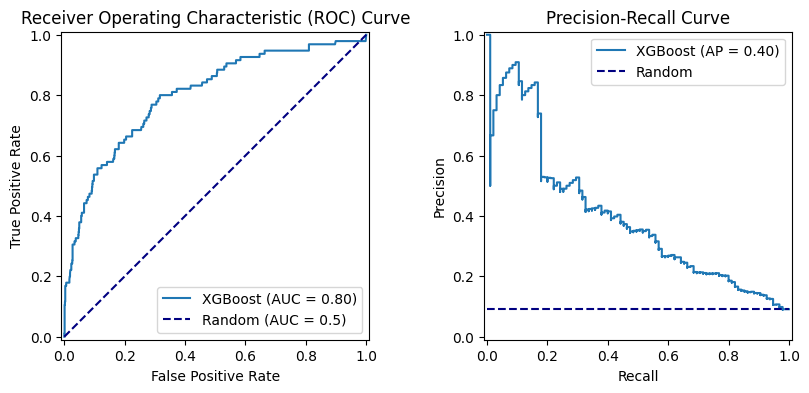

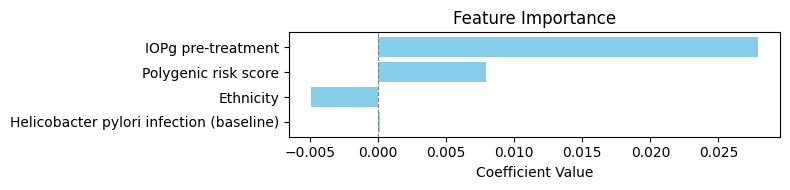

In [55]:
# using this one

# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_matched5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_matched5year_tte['feature']]

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    colsample_bytree = 0.8975,
    gamma = 0.001685,
    reg_lambda = 13.04,
    learning_rate = 0.006598,
    max_bin = 485,
    max_depth = 5,
    min_child_weight = 0.0005298,
    n_estimators = 267,
    subsample = 0.7121,
    random_state=1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), 
    eval_metric='logloss')


# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)


# Feature importance (XGBoost provides feature importance scores)
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_matched5year_tte['feature'],
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (XGBoost):")
    print(feature_importance)




# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # You'll need to calculate this
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost')
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (AUC = 0.5)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name='XGBoost')
pr_display.plot(ax=ax2)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='Random')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="best")


# need to do this for negative feature importances for xgboost :(
perm_result = permutation_importance(
    xgb_model, X_test_selected, y_test, 
    n_repeats=100, random_state=2)

base_score = xgb_model.score(X_test_selected, y_test)
for feature in X_test_selected.columns:
    X_perturbed = X_test_selected.copy()
    X_perturbed[feature] += np.random.normal(0, 0.1, len(X_test_selected))


feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_matched5year_tte['feature'],
    'Importance': perm_result.importances_mean,
    'abs': abs(perm_result.importances_mean),
}).sort_values('abs', ascending=False)

plt.figure(figsize=(8, 2))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<br>

## 10 year

XGBoost Results:\
AUROC: 0.7668\
Accuracy: 0.7793\
Precision (PPV): 0.2314\
Recall (Sensitivity): 0.6132\
Specificity: 0.7960\
NPV: 0.9536\
F1 Score: 0.3360

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_matched10year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_matched10year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_matched10year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_matched10year_tte.pkl')
minimal_features_rfecv_matched10year_tte = feature_sets.minimal_features_rfecv_matched10year_tte


LGBM Results:
AUROC: 0.7486
Precision: 0.3243
Recall: 0.4444
F1 Score: 0.3750
Optimal Threshold: 0.1616

Confusion Matrix (TN, FP | FN, TP):
[[2201  225]
 [ 135  108]]

SHAP Feature Importance:
                                                 Feature  Abs Importance (shap)  Importance (shap)
                                      IOPg pre-treatment               0.127045          -0.003911
                 IOPg pre-treatment inter-eye difference               0.000000           0.000000
                                      Corneal hysteresis               0.006311           0.001859
                 Corneal hysteresis inter-eye difference               0.000000           0.000000
                               Corneal resistance factor               0.000000           0.000000
                                    Spherical equivalent               0.000000           0.000000
                                    Polygenic risk score               0.084204           0.003887
             

/home/eake191/.pyenv/versions/3.13.2/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/eake191/.pyenv/versions/3.13.2/lib/python3.13/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Text(0.5, 1.0, 'Precision-Recall Curve')

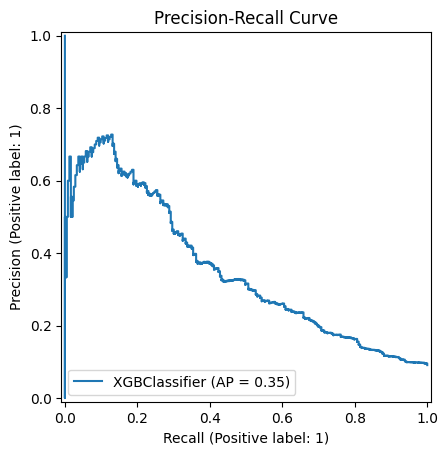

In [6]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_matched10year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types 
continuous_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'binary']['feature'].tolist()
ordinal_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'ordinal']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features),
        ('ordinal', 'passthrough', ordinal_features)  
    ])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
ordinal_feature_names = ordinal_features 
feature_names = np.concatenate([cont_feature_names, binary_feature_names, ordinal_feature_names])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
feature_names = np.concatenate([cont_feature_names, binary_feature_names])

# Initialize and train XGBoost with clinical constraints
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,  # Shallower trees for interpretability
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    min_child_weight=10,  # Require more samples per leaf
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'#,
    #verbosity=0
)



# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    verbose=False
)

# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance (more reliable)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer(X_test_preprocessed)

# Get mean absolute SHAP values for each feature
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': abs(shap_values.values).mean(axis=0),
    'Importance (shap)': shap_values.values.mean(axis=0)})
print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.pyplot.title('Precision-Recall Curve')


XGBoost Results:
AUROC: 0.7773
Precision: 0.4273
Recall: 0.3992
F1 Score: 0.4128
Optimal Threshold: 0.7035

Confusion Matrix 
TN FP
FN TP
[[2296  130]
 [ 146   97]]

SHAP Feature Importance:
                                Feature  Abs Importance (shap)  Importance (shap)
                     IOPg pre-treatment               0.763504          -0.368357
IOPg pre-treatment inter-eye difference               0.050861          -0.012336
                     Corneal hysteresis               0.167096          -0.019088
Corneal hysteresis inter-eye difference               0.052070          -0.006684
              Corneal resistance factor               0.060006          -0.020132
                   Spherical equivalent               0.102588          -0.032262
                   Polygenic risk score               0.363812          -0.119675
              Age at initial assesement               0.015929          -0.002618
                         PM2.5 exposure               0.019796        

AttributeError: module 'matplotlib.pyplot' has no attribute 'pyplot'

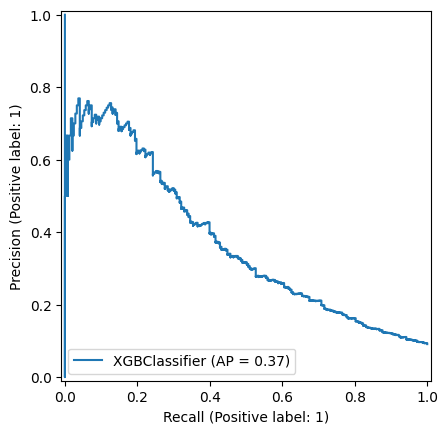

In [5]:
# Make sure we only use the selected features
selected_features = feature_sets.minimal_features_rfecv_matched10year_tte['feature'].tolist()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Identify feature types 
continuous_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'continuous']['feature'].tolist()
binary_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'binary']['feature'].tolist()
ordinal_features = feature_sets.minimal_features_rfecv_matched10year_tte[
    feature_sets.minimal_features_rfecv_matched10year_tte['coding_type'] == 'ordinal']['feature'].tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_features),
        ('binary', OneHotEncoder(drop='if_binary'), binary_features),
        ('ordinal', 'passthrough', ordinal_features)  
    ])

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train_selected)
X_test_preprocessed = preprocessor.transform(X_test_selected)

# Get feature names after preprocessing
cont_feature_names = continuous_features
binary_feature_names = preprocessor.named_transformers_['binary'].get_feature_names_out(binary_features)
ordinal_feature_names = ordinal_features 
feature_names = np.concatenate([cont_feature_names, binary_feature_names, ordinal_feature_names])

# Initialize and train XGBoost with clinical constraints
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=300,
    max_depth=3,  # Shallower trees for interpretability
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,  # Regularization
    min_child_weight=10,  # Require more samples per leaf
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42,
    eval_metric='aucpr'#,
    #verbosity=0
)



# Fit the model with early stopping
xgb_model.fit(
    X_train_preprocessed, y_train,
    eval_set=[(X_test_preprocessed, y_test)],
    verbose=False
)


# Make predictions
y_pred_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Find optimal threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_pred_proba >= optimal_threshold).astype(int)


# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Optimal Threshold: {thresholds[optimal_idx]:.4f}")
print("\nConfusion Matrix \nTN FP\nFN TP")
print(confusion_matrix(y_test, y_pred))

# SHAP feature importance with correct parameters
explainer = shap.TreeExplainer(
    xgb_model,
    feature_perturbation='tree_path_dependent',
    model_output='raw'  # Changed from 'probability' to 'raw'
)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_preprocessed)

# For binary classification, SHAP returns a list of arrays:
# [shap_values_class_0, shap_values_class_1]
# We typically use the positive class (class 1)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Get values for positive class

# Create DataFrame with feature importance
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Abs Importance (shap)': np.abs(shap_values).mean(axis=0),
    'Importance (shap)': shap_values.mean(axis=0)
})

print("\nSHAP Feature Importance:")
print(shap_df.to_string(index=False))


# Plot precision-recall curve
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(xgb_model, X_test_preprocessed, y_test)
plt.pyplot.title('Precision-Recall Curve')



XGBoost Results:
AUROC: 0.7668
Accuracy: 0.7793
Precision (PPV): 0.2314
Recall (Sensitivity): 0.6132
Specificity: 0.7960
NPV: 0.9536
F1 Score: 0.3360

Confusion Matrix 
TN FP 
FN TP:
[[1931  495]
 [  94  149]]

Feature Importance with Direction (Permutation):
                                    Feature  Importance  Direction
0                        IOPg pre-treatment    0.036190   0.751635
6                      Polygenic risk score   -0.012559   0.623184
1   IOPg pre-treatment inter-eye difference   -0.000378   0.276245
4                 Corneal resistance factor    0.002866   0.244626
2                        Corneal hysteresis    0.007452  -0.168146
9                                 Ethnicity   -0.001030  -0.146940
24                  Systolic blood pressure   -0.000652   0.146455
30                                    HbA1c    0.000622   0.122141
3   Corneal hysteresis inter-eye difference    0.001364   0.105014
76                         Plasma Vitamin D   -0.000663  -0.094926


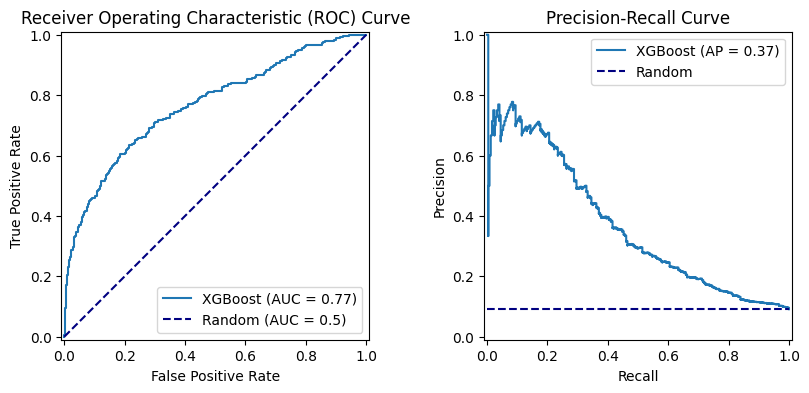

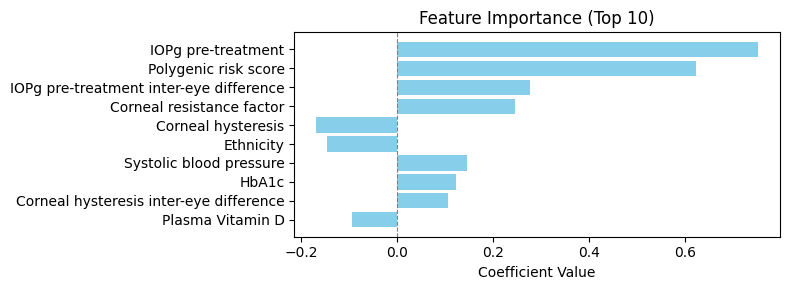

In [31]:
# using this one

# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_matched10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_matched10year_tte['feature']]

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    colsample_bytree = 0.8198,
    gamma = 0.004886,
    reg_lambda = 0.0229,
    learning_rate = 0.003109,
    max_bin = 143,
    max_depth = 4,
    min_child_weight = 0.08338,
    n_estimators = 254,
    subsample = 0.7802,
    random_state=1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), 
    eval_metric='logloss')


# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)



# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)  # You'll need to calculate this
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost')
roc_display.plot(ax=ax1)
ax1.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random (AUC = 0.5)')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

# Plot 2: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=average_precision, estimator_name='XGBoost')
pr_display.plot(ax=ax2)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], color='navy', linestyle='--', label='Random')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="best")


# use for negative values
perm_result = permutation_importance(
    xgb_model, X_test_selected, y_test, 
    n_repeats=100, random_state=2)

feature_directions = []
for feature in X_test_selected.columns:
    corr = np.corrcoef(X_test_selected[feature], y_pred_proba)[0, 1]
    feature_directions.append(corr)

feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_matched10year_tte['feature'],
    'Importance': perm_result.importances_mean,
    'Direction': feature_directions,
}).sort_values('Direction', key=abs, ascending=False)

print("\nFeature Importance with Direction (Permutation):")
print(feature_importance.head(10))

plt.figure(figsize=(8, 3))
fe10 = feature_importance.head(10)
plt.barh(fe10['Feature'], fe10['Direction'], color='skyblue')  
plt.xlabel('Coefficient Value')
plt.title('Feature Importance (Top 10)')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<br>

<br>

---

# No IOP models

### 3 year

Logistic Regression Results:\
AUROC: 0.7295\
Accuracy: 0.6820\
Precision (PPV): 0.0057\
Recall (Sensitivity): 0.6679\
Specificity: 0.6821\
NPV: 0.9987\
F1 Score: 0.0113

In [3]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_IOPremoved3year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_IOPremoved3year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_IOPremoved3year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_IOPremoved3year_tte.pkl')
minimal_features_rfecv_IOPremoved3year_tte = feature_sets.minimal_features_rfecv_IOPremoved3year_tte

In [3]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved3year_tte['feature']]


# Option 2: Simple imputation (if you prefer not to drop)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_train_selected = imputer.fit_transform(X_train_selected)
X_test_selected = imputer.transform(X_test_selected)

# Initialize and train logistic regression model
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced' )

# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_IOPremoved3year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    pd.set_option('display.width', 1000)
    
    print("\nFeature Importance Analysis:")
    print(feature_importance.to_string(index=False, justify='left'))


Logistic Regression Results:
AUROC: 0.7307
Precision: 0.0057
Recall: 0.6717
F1 Score: 0.0113

Confusion Matrix 
TN FP 
FN TP:
[[66216 30939]
 [   87   178]]

Feature Importance Analysis:
Feature                                               Coefficient  Abs Coefficient
                                Polygenic risk score  6.718457    6.718457        
                           Age at initial assesement  2.915093    2.915093        
                                          Tea intake -2.245549    2.245549        
                                      Plasma glucose  1.362898    1.362898        
                                     Body mass index -1.167438    1.167438        
                             Systolic blood pressure  0.977431    0.977431        
                       Other hearing loss (baseline)  0.924833    0.924833        
                               eGFR serum creatinine  0.837996    0.837996        
                         Anxiety disorder (baseline)  0.761321   

In [4]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved3year_tte['feature']]


logreg = SGDClassifier(
    loss='log_loss',           
    penalty='l2',
    alpha=3.702e-06, # optimal hyperparameter 
    eta0=0.09981,
    max_iter=1000,
    random_state=3,
    class_weight='balanced',
    tol=1e-3,                  
    learning_rate='adaptive', # optimal hyperparameter              
    fit_intercept=True,
    n_iter_no_change=5)


# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_IOPremoved3year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    


Logistic Regression Results:
AUROC: 0.7295
Accuracy: 0.6820
Precision (PPV): 0.0057
Recall (Sensitivity): 0.6679
Specificity: 0.6821
NPV: 0.9987
F1 Score: 0.0113

Confusion Matrix 
TN FP 
FN TP:
[[66266 30889]
 [   88   177]]

Feature Importance (Coefficients):
                                              Feature  Coefficient  \
0                                Polygenic risk score     6.917900   
81                                         Tea intake    -3.616685   
1                           Age at initial assesement     2.967682   
24                                              HbA1c     2.228745   
69                                    Body mass index    -1.282281   
25                                     Plasma glucose     1.110249   
34                              eGFR serum creatinine     1.036665   
17                      Other hearing loss (baseline)     0.944329   
18                            Systolic blood pressure     0.917933   
32                            Sleep a

### 5 year

Logistic Regression Results:\
AUROC: 0.7531\
Accuracy: 0.6848\
Precision (PPV): 0.0105\
Recall (Sensitivity): 0.6807\
Specificity: 0.6848\
NPV: 0.9977\
F1 Score: 0.0206

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_IOPremoved5year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_IOPremoved5year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_IOPremoved5year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_IOPremoved5year_tte.pkl')
minimal_features_rfecv_IOPremoved5year_tte = feature_sets.minimal_features_rfecv_IOPremoved5year_tte

In [3]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved5year_tte['feature']]


# Option 2: Simple imputation (if you prefer not to drop)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  # or 'median', 'most_frequent'
X_train_selected = imputer.fit_transform(X_train_selected)
X_test_selected = imputer.transform(X_test_selected)

# Initialize and train logistic regression model
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced' )

# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_IOPremoved5year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    pd.set_option('display.width', 1000)
    
    print("\nFeature Importance Analysis:")
    print(feature_importance.to_string(index=False, justify='left'))


Logistic Regression Results:
AUROC: 0.7526
Precision: 0.0106
Recall: 0.6912
F1 Score: 0.0209

Confusion Matrix 
TN FP 
FN TP:
[[66479 30676]
 [  147   329]]

Feature Importance Analysis:
Feature                                               Coefficient  Abs Coefficient
                                Polygenic risk score  6.473090    6.473090        
                           Age at initial assesement  2.844921    2.844921        
                                      Plasma glucose  1.834261    1.834261        
                              Plasma total bilirubin -1.315578    1.315578        
                                   Plasma oestradiol -1.069845    1.069845        
                                          Tea intake -0.894601    0.894601        
                             Systolic blood pressure  0.841954    0.841954        
                                      PM2.5 exposure  0.788698    0.788698        
Conductive and sensorineural hearing loss (baseline)  0.713744   

In [3]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved5year_tte['feature']]


logreg = SGDClassifier(
    loss='log_loss',           
    penalty='l2',
    alpha=6.263e-06, # optimal hyperparameter 
    eta0=0.06847,    # optimal hyperparameter 
    max_iter=1000,
    random_state=3,
    class_weight='balanced',
    tol=1e-3,                  
    learning_rate='adaptive', # optimal hyperparameter              
    fit_intercept=True,
    n_iter_no_change=5)


# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_IOPremoved5year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    


Logistic Regression Results:
AUROC: 0.7531
Accuracy: 0.6848
Precision (PPV): 0.0105
Recall (Sensitivity): 0.6807
Specificity: 0.6848
NPV: 0.9977
F1 Score: 0.0206

Confusion Matrix 
TN FP 
FN TP:
[[66536 30619]
 [  152   324]]

Feature Importance (Coefficients):
                            Feature  Coefficient  Abs Coefficient
0              Polygenic risk score     6.639303         6.639303
79  Urinary sodium-creatinine ratio    -5.091719         5.091719
1         Age at initial assesement     2.923265         2.923265
25                   Plasma glucose     2.763534         2.763534
24                            HbA1c    -2.453943         2.453943
..                              ...          ...              ...
88       Daytime sleeping frequency    -0.011129         0.011129
31         Dyslipidaemia (baseline)    -0.010913         0.010913
41                 Poor oral health    -0.006937         0.006937
77          Calcium supplementation     0.005983         0.005983
76         

### 10 year

LightGBM Results:\
AUROC: 0.7405\
Accuracy: 0.6711\
Precision (PPV): 0.0240\
Recall (Sensitivity): 0.6753\
Specificity: 0.6710\
NPV: 0.9942\
F1 Score: 0.0464

In [285]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_IOPremoved10year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_IOPremoved10year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_IOPremoved10year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_IOPremoved10year_tte.pkl')
minimal_features_rfecv_IOPremoved10year_tte = feature_sets.minimal_features_rfecv_IOPremoved10year_tte

In [202]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved10year_tte['feature']]


# Initialize and train LightGBM model
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)

# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLGBM Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_IOPremoved10year_tte['feature'],
    'Importance': lgb_model.feature_importances_  # Changed from coef_[0]
}).sort_values('Importance', ascending=False)  # Changed from 'Abs Coefficient'

pd.set_option('display.width', 1000)

print("\nFeature Importance Analysis:")
print(feature_importance.to_string(index=False, justify='left'))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4654, number of negative: 388617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2518
[LightGBM] [Info] Number of data points in the train set: 393271, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

LGBM Results:
AUROC: 0.7305
Precision: 0.0250
Recall: 0.6091
F1 Score: 0.0480

Confusion Matrix 
TN FP 
FN TP:
[[69492 27663]
 [  455   709]]

Feature Importance Analysis:
Feature                                               Importance
                                Polygenic risk score 428        
                                     Body mass index 278    

In [286]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_IOPremoved10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_IOPremoved10year_tte['feature']]

# Initialize and train LightGBM model with optimized hyperparameters
lgb_model = lgb.LGBMClassifier(
    bagging_fraction=0.562,
    feature_fraction=0.6229,
    reg_lambda=0.829,      
    learning_rate=0.02472,
    max_bin=892,
    max_depth=3,
    min_child_samples=204,   
    min_child_weight=0.004022,  
    n_estimators=369,
    num_leaves=112,
    random_state=1,
    class_weight='balanced')


# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1] 


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLightGBM Results (Optimized Hyperparameters):")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)



# Feature importance (LightGBM provides feature importance scores)
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_IOPremoved10year_tte['feature'],
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (LightGBM):")
    print(feature_importance)


[LightGBM] [Warning] feature_fraction is set=0.6229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6229
[LightGBM] [Warning] bagging_fraction is set=0.562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6229
[LightGBM] [Warning] bagging_fraction is set=0.562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562
[LightGBM] [Info] Number of positive: 4654, number of negative: 388617
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7653
[LightGBM] [Info] Number of data points in the train set: 393271, number of used featur

### risk histogram with IH

[LightGBM] [Warning] feature_fraction is set=0.6229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6229
[LightGBM] [Warning] bagging_fraction is set=0.562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562


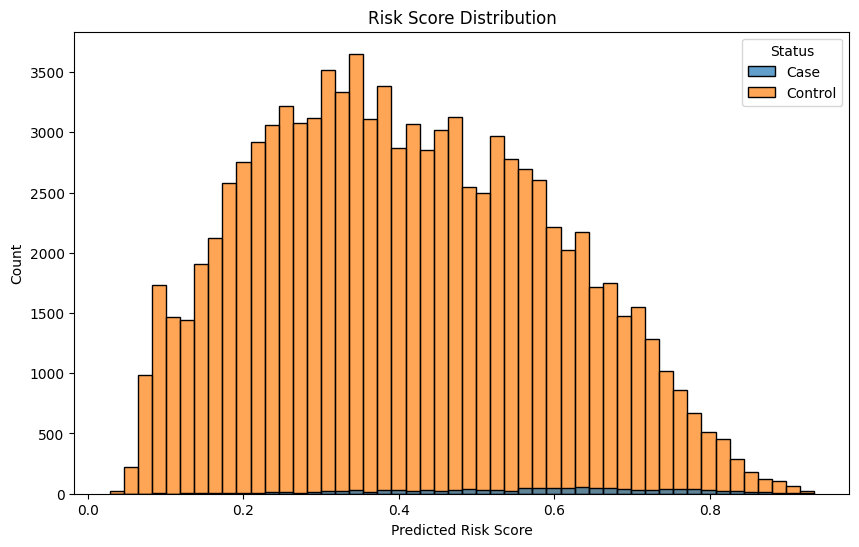

In [97]:
# risk score histogram for cases and controls
y_pred_proba = lgb_model.predict_proba(X_test_selected)  
risk_scores = y_pred_proba[:, 1]  


plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'actual_case': y_test })

plot_data['Status'] = plot_data['actual_case'].map({0: 'Control', 1: 'Case'})


# histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, x='risk_score', hue='Status', bins=50, alpha=0.7, multiple='layer')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution')
plt.show()

In [107]:
IH = pd.read_table('IH_data.txt').rename(columns={'Participant_ID': 'ID'})[['ID', 'prevalent_IIH']]
IOPremoved = pd.read_csv('../IOPremoved_10year_tte.csv').rename(columns={'f.eid': 'ID'})[['ID', 'tte_10year_80_20_split']]

/tmp/ipykernel_1975809/1804796529.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  IOPremoved = pd.read_csv('../IOPremoved_10year_tte.csv').rename(columns={'f.eid': 'ID'})[['ID', 'tte_10year_80_20_split']]


In [108]:
IOPremoved

,ID,tte_10year_80_20_split
0,1574740,train
1,2987070,train
2,4213729,train
3,5208631,train
4,2673197,train
...,...,...
491585,3826917,test
491586,3662640,test
491587,2339182,test
491588,2768972,test


In [113]:
IOPremovedtest = IOPremoved.drop(IOPremoved[IOPremoved['tte_10year_80_20_split'].str.contains('train')].index)

In [114]:
IOPremovedtest

,ID,tte_10year_80_20_split
393271,4922807,test
393272,3542582,test
393273,2970597,test
393274,5515955,test
393275,5277976,test
...,...,...
491585,3826917,test
491586,3662640,test
491587,2339182,test
491588,2768972,test


In [115]:
# examining intracranial hypertension
IOPremovedtest = IOPremoved.drop(IOPremoved[IOPremoved['tte_10year_80_20_split'].str.contains('train')].index)
glaucoma_IH = pd.merge(IH, IOPremovedtest, on = 'ID')

# number of IH cases in the test set
glaucoma_IH['prevalent_IIH'].value_counts()

prevalent_IIH
0.0    98249
1.0       70
Name: count, dtype: int64

[LightGBM] [Warning] feature_fraction is set=0.6229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6229
[LightGBM] [Warning] bagging_fraction is set=0.562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562


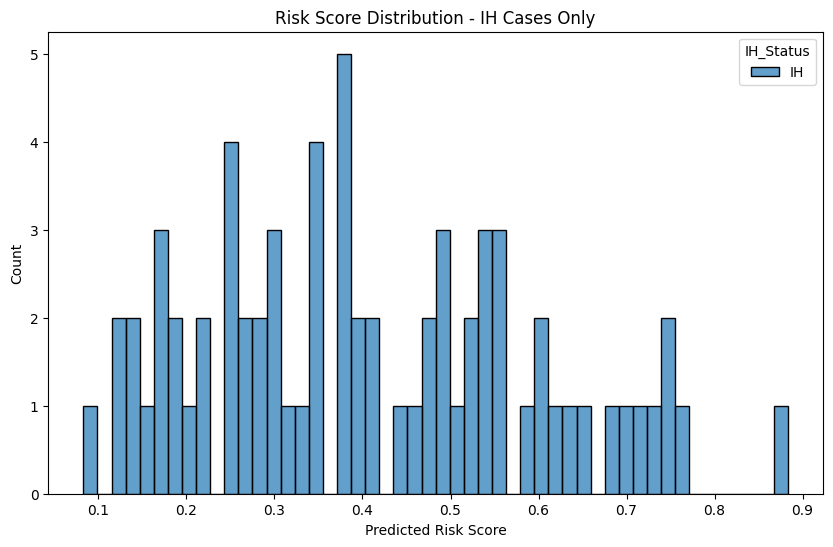

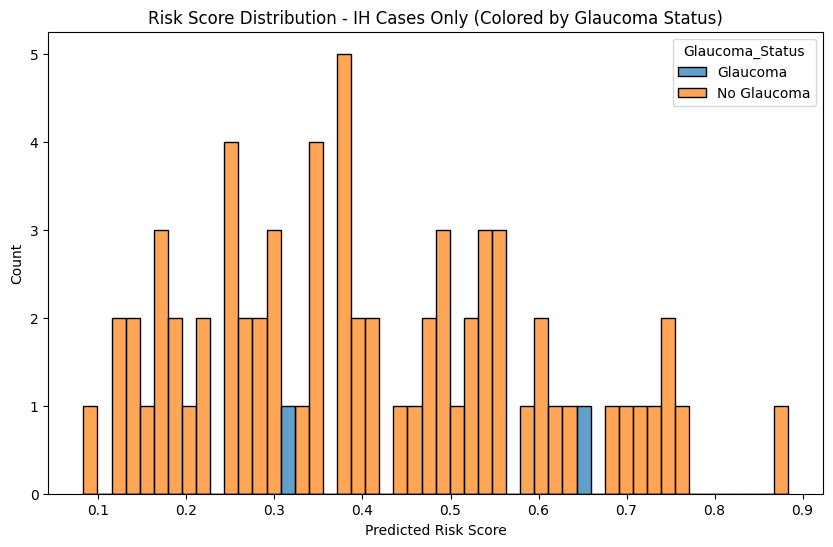

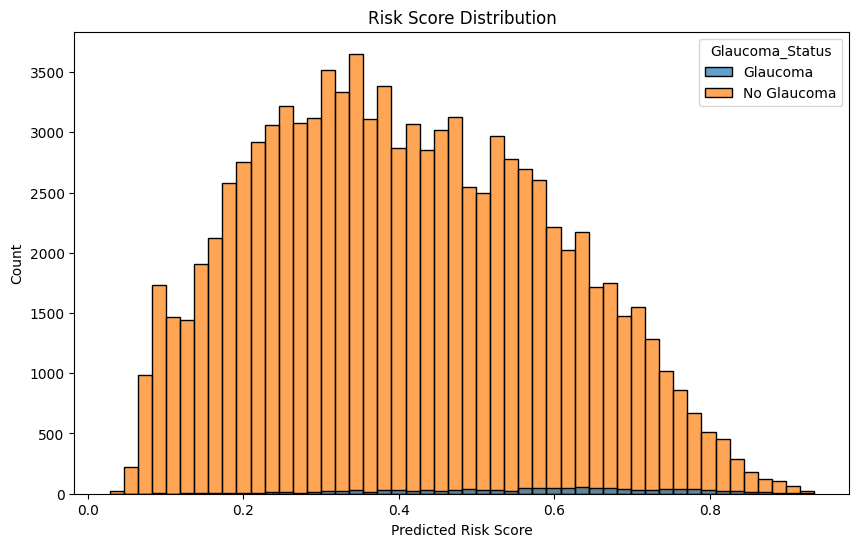

In [122]:
# risk score histogram for IH
y_pred_proba = lgb_model.predict_proba(X_test_selected)  
risk_scores = y_pred_proba[:, 1]  


plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'actual_IH_case': glaucoma_IH['prevalent_IIH'],
    'glaucoma_case': y_test  
})

plot_data['IH_Status'] = plot_data['actual_IH_case'].map({0: 'No IH', 1: 'IH'})
plot_data['Glaucoma_Status'] = plot_data['glaucoma_case'].map({0: 'No Glaucoma', 1: 'Glaucoma'})




# histogram for IH cases only
plot_data_cases_only = plot_data[plot_data['actual_IH_case'] == 1]
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data_cases_only, x='risk_score', hue='IH_Status', bins=50, alpha=0.7, multiple='layer')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution - IH Cases Only')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data_cases_only, x='risk_score', hue='Glaucoma_Status', bins=50, alpha=0.7, multiple='layer')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution - IH Cases Only (Colored by Glaucoma Status)')
plt.show()


# histogram for IH case/control
plt.figure(figsize=(10, 6))
sns.histplot(data=plot_data, x='risk_score', hue='IH_Status', bins=50, alpha=0.7, multiple='layer')
plt.xlabel('Predicted Risk Score')
plt.title('Risk Score Distribution')
plt.show()

### risk histogram with other diseases

/tmp/ipykernel_974832/3221637947.py:8: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  matched = pd.read_csv('../IOPremoved_10year_tte.csv').rename(columns={'f.eid': 'ID'})[['ID', 'tte_10year_80_20_split']]


[LightGBM] [Warning] feature_fraction is set=0.6229, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6229
[LightGBM] [Warning] bagging_fraction is set=0.562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.562

MS Group Counts:
  Glaucoma + MS: 29
  Glaucoma + No MS: 5789
  No Glaucoma + MS: 2465
  No Glaucoma + No MS: 483307


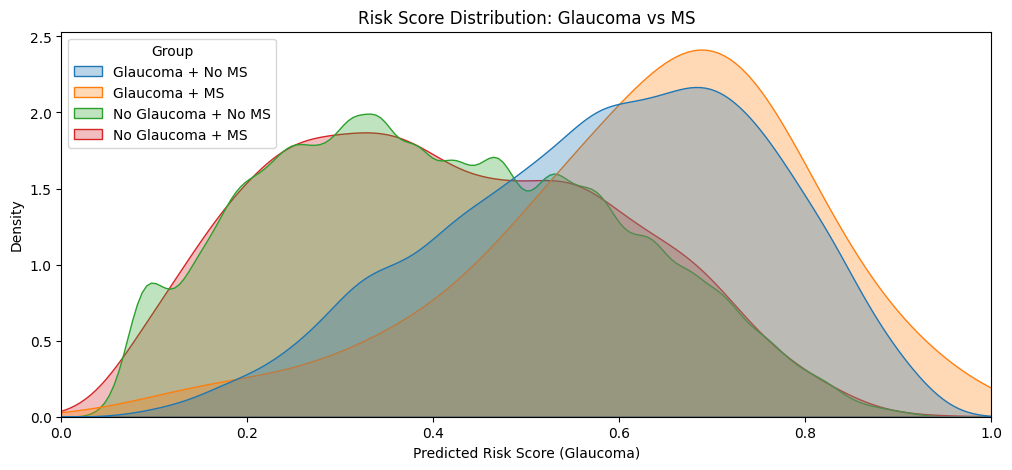


ALZD Group Counts:
  Glaucoma + ALZD: 30
  Glaucoma + No ALZD: 5788
  No Glaucoma + ALZD: 2686
  No Glaucoma + No ALZD: 483086


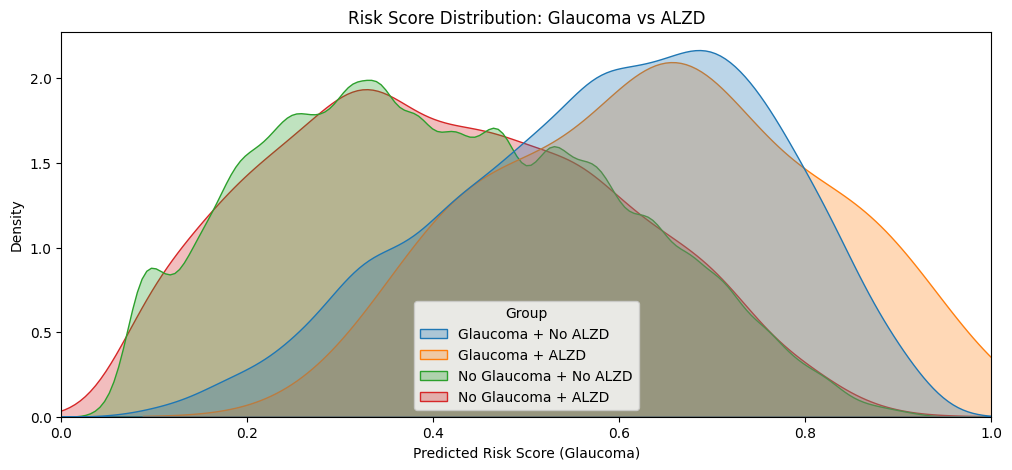


PD Group Counts:
  Glaucoma + No PD: 5780
  Glaucoma + PD: 38
  No Glaucoma + No PD: 482300
  No Glaucoma + PD: 3472


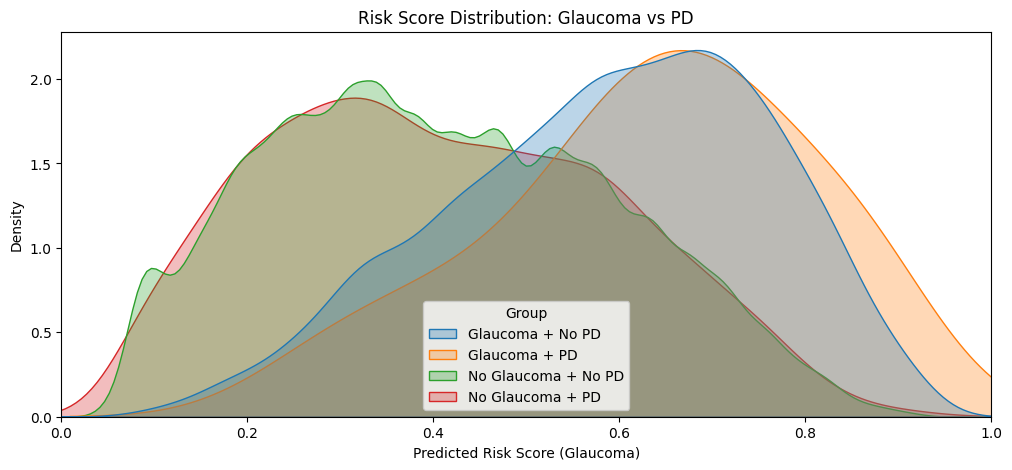


APOE4 Group Counts:
  Glaucoma + APOE4: 121
  Glaucoma + No APOE4: 5548
  No Glaucoma + APOE4: 11237
  No Glaucoma + No APOE4: 459833


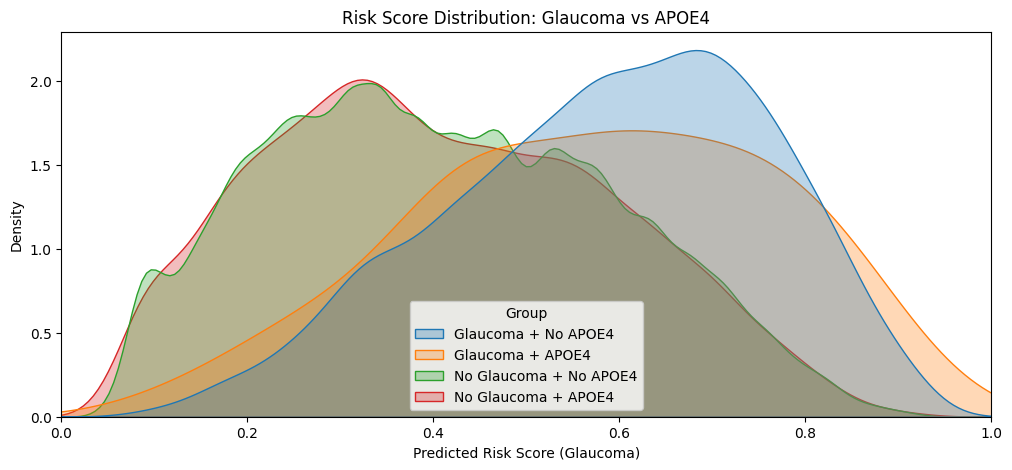


Cataracts Group Counts:
  Glaucoma + Cataracts: 748
  Glaucoma + No Cataracts: 5070
  No Glaucoma + Cataracts: 63570
  No Glaucoma + No Cataracts: 422202


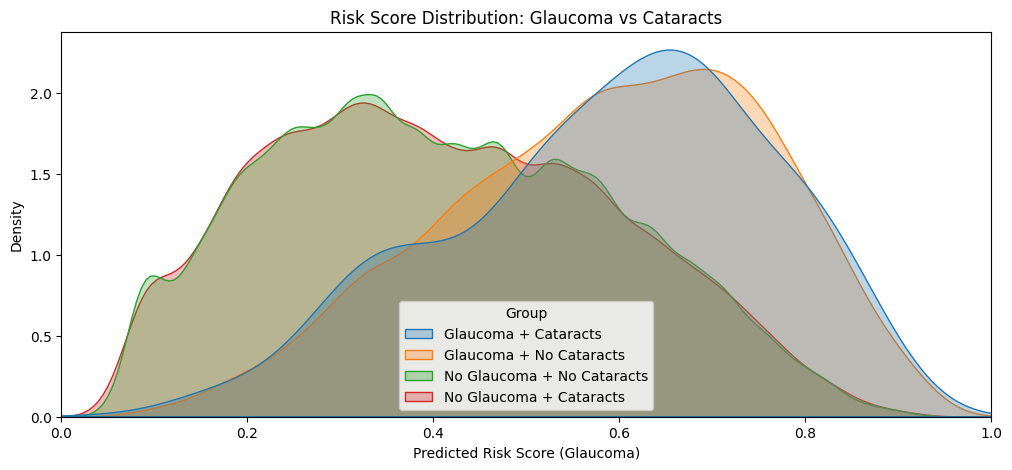


AMD Group Counts:
  Glaucoma + AMD: 152
  Glaucoma + No AMD: 5666
  No Glaucoma + AMD: 13341
  No Glaucoma + No AMD: 472431


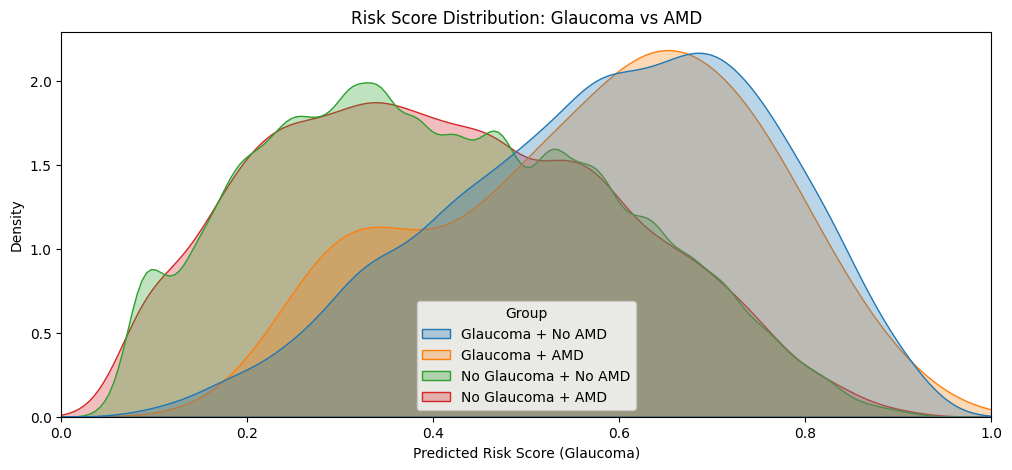


DR Group Counts:
  Glaucoma + DR: 126
  Glaucoma + No DR: 5692
  No Glaucoma + DR: 10332
  No Glaucoma + No DR: 475440


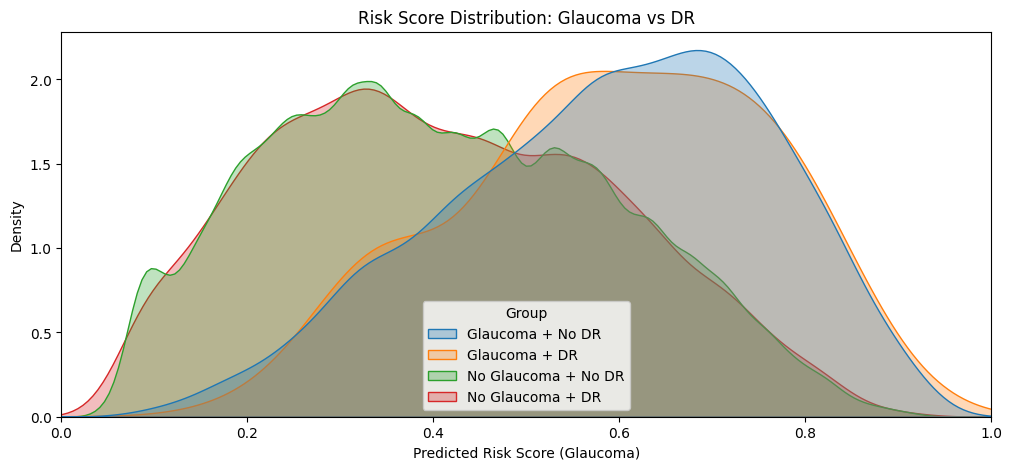

In [287]:
# all histograms with the other diseases against glaucoma risk
glaucoma_diseases = pd.read_table('IH_data.txt').rename(columns={'Participant_ID': 'ID'})[['ID', 'MS', 'ALZD', 'PD', 'APOE4', 'cat_prevalence', 'AMD_prevalence', 'DR_prevalence']]
cohort_ids = pd.read_csv('../william.csv')
ids = cohort_ids[['ID', 'IOP_removed_3']]
glaucoma_diseases = pd.merge(prs, ids, on = 'ID').dropna()

glaucoma_diseases = pd.read_table('IH_data.txt').rename(columns={'Participant_ID': 'ID'})
matched = pd.read_csv('../IOPremoved_10year_tte.csv').rename(columns={'f.eid': 'ID'})[['ID', 'tte_10year_80_20_split']]
glaucoma_diseases = pd.merge(glaucoma_diseases, matched, on='ID')

# glaucoma risk score against disease prevalence
X_full = pd.concat([X_train_selected, X_test_selected])
y_full = pd.concat([y_train, y_test])
risk_scores = lgb_model.predict_proba(X_full)[:, 1]

# Create lists/arrays instead of pandas Series to avoid index issues
plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'ID': glaucoma_diseases['ID'],
    'MS': glaucoma_diseases['MS'].map({'Control': 'No MS', 'MS':'MS'}).values,
    'ALZD': glaucoma_diseases['ALZD'].map({'Control': 'No ALZD', 'ALZD':'ALZD'}).values,
    'PD': glaucoma_diseases['PD'].map({'Control': 'No PD', 'PD':'PD'}).values,
    'APOE4': glaucoma_diseases['APOE4'].map({'Control': 'No APOE4', 'APOE4':'APOE4'}).values,
    'Cataracts': glaucoma_diseases['cat_prevalence'].map({0: 'No Cataracts', 1: 'Cataracts'}).values,
    'AMD': glaucoma_diseases['AMD_prevalence'].map({0: 'No AMD', 1: 'AMD'}).values,
    'DR': glaucoma_diseases['DR_prevalence'].map({0: 'No DR', 1: 'DR'}).values,
    'Glaucoma': y_full.map({0: 'No Glaucoma', 1: 'Glaucoma'}).values
})

# for the diagnosis source histogram
cases_only = plot_data.loc[plot_data['Glaucoma'] == 'Glaucoma']

'''
# disease against risk score: 
plot_data = plot_data.sample(frac=1, random_state=1).reset_index(drop=True) # shuffling the data because DR & Glaucoma colours were messed up
for disease in plot_data.drop(columns='risk_score'):
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=plot_data, x='risk_score', hue=disease, alpha=0.3, common_norm=False, fill=True)
    plt.xlabel('Predicted Risk Score')
    plt.title(f'Risk Score Distribution by {disease}')
    plt.show() '''


for disease in plot_data.drop(columns=['ID', 'risk_score', 'Glaucoma']):
    plt.figure(figsize=(12, 5))
    plot_data['Group'] = plot_data['Glaucoma'] + ' + ' + plot_data[disease]

    print(f"\n{disease} Group Counts:")
    for group, count in plot_data['Group'].value_counts().sort_index().items():
        print(f"  {group}: {count}")
    
    sns.kdeplot(data=plot_data, x='risk_score', hue='Group', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
    plt.xlabel('Predicted Risk Score (Glaucoma)')
    plt.title(f'Risk Score Distribution: Glaucoma vs {disease}')
    plt.xlim(0, 1)
    plt.show()

Neurodegenerative disease group counts:
  Glaucoma + AZHD/PD/MS: 95
  Glaucoma + No AZHD/PD/MS: 5723
  No Glaucoma + AZHD/PD/MS: 8381
  No Glaucoma + No AZHD/PD/MS: 477391


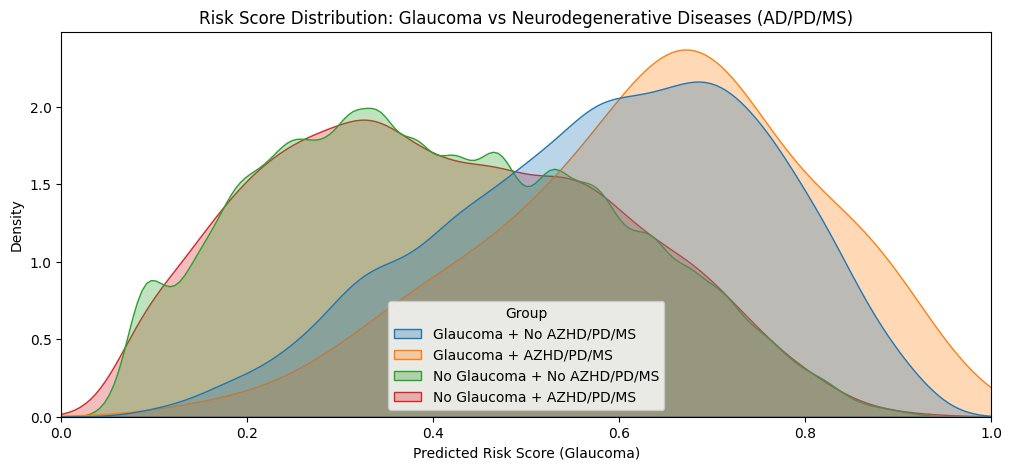

In [220]:
# histogram with glaucoma risk against all neurodegenerative diseases
plot_data = pd.DataFrame({
    'risk_score': risk_scores,
    'Glaucoma': y_full.map({0: 'No Glaucoma', 1: 'Glaucoma'}).values
})

# Create neurodegenerative disease group (ANY of ALZD, PD, or MS)
has_neurodegenerative = (
    (glaucoma_diseases['ALZD'] == 'ALZD') | 
    (glaucoma_diseases['PD'] == 'PD') | 
    (glaucoma_diseases['MS'] == 'MS')
)

plot_data['Neurodegenerative'] = np.where(
    has_neurodegenerative, 
    'AZHD/PD/MS', 
    'No AZHD/PD/MS'
)

# Create the four combined groups
plot_data['Group'] = plot_data['Glaucoma'] + ' + ' + plot_data['Neurodegenerative']

print("Neurodegenerative disease group counts:")
for group, count in plot_data['Group'].value_counts().sort_index().items():
    print(f"  {group}: {count}")

# Create the plot
plt.figure(figsize=(12, 5))
sns.kdeplot(data=plot_data, x='risk_score', hue='Group', alpha=0.3, common_norm=False, fill=True, warn_singular=False)
plt.xlabel('Predicted Risk Score (Glaucoma)')
plt.title('Risk Score Distribution: Glaucoma vs Neurodegenerative Diseases (AD/PD/MS)')
plt.xlim(0, 1)
plt.show()

<br>

<br>

---

# RNFL models

### 3 year
Logistic Regression Results:\
AUROC: 0.8680\
Accuracy: 0.7967\
Precision (PPV): 0.0081\
Recall (Sensitivity): 0.7500\
Specificity: 0.7968\
NPV: 0.9993\
F1 Score: 0.0160

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_rnfl3year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_rnfl3year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_rnfl3year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_rnfl3year_tte.pkl')
minimal_features_rfecv_3year_tte = feature_sets_rnfl.minimal_features_rfecv_rnfl3year_tte

In [6]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_3year_tte['feature']]



# Initialize and train logistic regression model
logreg = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)

# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_3year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    


Logistic Regression Results:
AUROC: 0.8804
Precision: 0.0091
Recall: 0.7917
F1 Score: 0.0179

Confusion Matrix 
TN FP 
FN TP:
[[17535  4152]
 [   10    38]]

Feature Importance (Coefficients):
                                    Feature  Coefficient  Abs Coefficient
0                        IOPg pre-treatment    14.819956        14.819956
6                                      RNFL    -8.246661         8.246661
2                        Corneal hysteresis    -6.434589         6.434589
8                      Polygenic risk score     5.352797         5.352797
5                      Spherical equivalent    -3.324095         3.324095
1   IOPg pre-treatment inter-eye difference    -3.025166         3.025166
9                 Age at initial assesement     2.946020         2.946020
14               Townsend deprivation index     1.179066         1.179066
11                                Ethnicity    -1.109872         1.109872
7                                       GCL     1.069297         1

In [3]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_3year_tte['feature']]


logreg = SGDClassifier(
    loss='log_loss',           
    penalty='l2',
    alpha=1.027e-06, # optimal hyperparameter 
    max_iter=1000,
    random_state=3,
    class_weight='balanced',
    tol=1e-3,                  
    learning_rate='optimal', # optimal hyperparameter              
    fit_intercept=True,
    n_iter_no_change=5)


# Fit the model
logreg.fit(X_train_selected, y_train)

# Make predictions
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLogistic Regression Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature coefficients
if hasattr(logreg, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_3year_tte['feature'],
        'Coefficient': logreg.coef_[0],
        'Abs Coefficient': abs(logreg.coef_[0])
    }).sort_values('Abs Coefficient', ascending=False)
    
    print("\nFeature Importance (Coefficients):")
    print(feature_importance)
    


Logistic Regression Results:
AUROC: 0.8680
Accuracy: 0.7967
Precision (PPV): 0.0081
Recall (Sensitivity): 0.7500
Specificity: 0.7968
NPV: 0.9993
F1 Score: 0.0160

Confusion Matrix 
TN FP 
FN TP:
[[17281  4406]
 [   12    36]]

Feature Importance (Coefficients):
                                    Feature  Coefficient  Abs Coefficient
0                        IOPg pre-treatment   292.787040       292.787040
6                                      RNFL  -209.321964       209.321964
8                      Polygenic risk score   125.097585       125.097585
2                        Corneal hysteresis  -113.937008       113.937008
1   IOPg pre-treatment inter-eye difference   -98.376192        98.376192
9                 Age at initial assesement    52.616356        52.616356
5                      Spherical equivalent   -48.897359        48.897359
12                           PM2.5 exposure   -28.070017        28.070017
14               Townsend deprivation index    22.702168        22.7021

<br>

### 5 year

XGBoost Results:\
AUROC: 0.8319\
Accuracy: 0.8739\
Precision (PPV): 0.0199\
Recall (Sensitivity): 0.5789\
Specificity: 0.8752\
NPV: 0.9979\
F1 Score: 0.0385



In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_rnfl5year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_rnfl5year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_rnfl5year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_rnfl5year_tte.pkl')
minimal_features_rfecv_rnfl5year_tte = feature_sets_rnfl.minimal_features_rfecv_rnfl5year_tte

In [16]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_rnfl5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_rnfl5year_tte['feature']]


# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    random_state=42
)

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_rnfl5year_tte['feature'],
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


XGBoost Results:
AUROC: 0.7469
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000

Confusion Matrix 
TN FP 
FN TP:
[[21686     1]
 [   95     0]]

Feature Importance:
                                    Feature  Importance
0                        IOPg pre-treatment    0.095135
67                                Metformin    0.056010
69                             Beta blocker    0.038104
70                  Calcium channel blocker    0.037606
52      Irritable bowel syndrome (baseline)    0.034008
2                        Corneal hysteresis    0.032764
9                 Age at initial assesement    0.030694
93                    Normal sleep duration    0.030562
59             Atopic dermatitis (baseline)    0.029224
8                      Polygenic risk score    0.028406
44        Chronic kidney disease (baseline)    0.023982
19                      Migraine (baseline)    0.023791
45                        Plasma oestradiol    0.021806
96               Daytime sleeping frequency    0.

In [18]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_rnfl5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_rnfl5year_tte['feature']]


# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),  # Handle class imbalance
    eval_metric='logloss'
)

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

# Feature importance (XGBoost built-in)
feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_rnfl5year_tte['feature'],
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (XGBoost):")
print(feature_importance)



XGBoost Results:
AUROC: 0.8195
Accuracy: 0.8734
Precision: 0.0202
Recall: 0.5895
F1 Score: 0.0390

Confusion Matrix 
TN FP 
FN TP:
[[18968  2719]
 [   39    56]]

Feature Importance (XGBoost):
                                    Feature  Importance
0                        IOPg pre-treatment    0.071063
8                      Polygenic risk score    0.056766
9                 Age at initial assesement    0.042615
11                                Ethnicity    0.037832
19                      Migraine (baseline)    0.035059
16                                Education    0.032248
85                  Calcium supplementation    0.031117
15                   Total household income    0.030016
90                           Alcohol intake    0.029656
3   Corneal hysteresis inter-eye difference    0.028640
7                                       GCL    0.027632
32                                    HbA1c    0.025764
2                        Corneal hysteresis    0.024841
65                   P

In [3]:
# using this one

# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_rnfl5year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_rnfl5year_tte['feature']]

# Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(
    colsample_bytree = 0.7916,
    gamma = 0.0005305,
    reg_lambda = 0.6983,
    learning_rate = 0.01412,
    max_bin = 945,
    max_depth = 4,
    min_child_weight = 0.02134,
    n_estimators = 258,
    subsample = 0.8237,
    random_state=1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]), 
    eval_metric='logloss')

# Fit the model
xgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test_selected)
y_pred_proba = xgb_model.predict_proba(X_test_selected)[:, 1] 

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nXGBoost Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)


# Feature importance (XGBoost provides feature importance scores)
if hasattr(xgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_rnfl5year_tte['feature'],
        'Importance': xgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (XGBoost):")
    print(feature_importance)


XGBoost Results:
AUROC: 0.8319
Accuracy: 0.8739
Precision (PPV): 0.0199
Recall (Sensitivity): 0.5789
Specificity: 0.8752
NPV: 0.9979
F1 Score: 0.0385

Confusion Matrix 
TN FP 
FN TP:
[[18980  2707]
 [   40    55]]

Feature Importance (XGBoost):
                                    Feature  Importance
0                        IOPg pre-treatment    0.067640
8                      Polygenic risk score    0.049543
67                                Metformin    0.035473
11                                Ethnicity    0.032564
9                 Age at initial assesement    0.031269
90                           Alcohol intake    0.029399
79                               Diet score    0.027999
1   IOPg pre-treatment inter-eye difference    0.026536
19                      Migraine (baseline)    0.025830
7                                       GCL    0.025691
84                 Selenium supplementation    0.025576
96               Daytime sleeping frequency    0.025261
14               Townsend 

## 10 year

LGBM Results:\
AUROC: 0.8163\
Precision: 0.0734\
Recall: 0.4815\
F1 Score: 0.1275


In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_rnfl10year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_rnfl10year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_rnfl10year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_rnfl10year_tte.pkl')
minimal_features_rfecv_rnfl10year_tte = feature_sets_rnfl.minimal_features_rfecv_rnfl10year_tte

In [13]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_rnfl10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_rnfl10year_tte['feature']]


# Initialize and train LightGBM model
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)

# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLGBM Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_rnfl10year_tte['feature'],
    'Importance': lgb_model.feature_importances_  
}).sort_values('Importance', ascending=False) 

pd.set_option('display.width', 1000)

print("\nFeature Importance Analysis:")
print(feature_importance.to_string(index=False, justify='left'))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 970, number of negative: 86744
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8475
[LightGBM] [Info] Number of data points in the train set: 87714, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

LGBM Results:
AUROC: 0.8163
Precision: 0.0734
Recall: 0.4815
F1 Score: 0.1275

Confusion Matrix 
TN FP 
FN TP:
[[20211  1476]
 [  126   117]]

Feature Importance Analysis:
Feature                                  Importance
                     IOPg pre-treatment 183        
                   Polygenic risk score 132        
Corneal hysteresis inter-eye differen

In [3]:
# using this one
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_rnfl10year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_rnfl10year_tte['feature']]

# Initialize and train LightGBM model with optimized hyperparameters
lgb_model = lgb.LGBMClassifier(
    bagging_fraction=0.7567,
    feature_fraction=0.686,
    reg_lambda=5.634,      
    learning_rate=0.02946,
    max_bin=899,
    max_depth=3,
    min_child_samples=615,   
    min_child_weight=0.00152,  
    n_estimators=342,
    num_leaves=125,
    random_state=1,
    class_weight='balanced')


# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1] 


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate additional metrics from confusion matrix
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Positive Predictive Value (Precision)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value

# Print results
print("\nLightGBM Results (Optimized Hyperparameters):")
print(f"AUROC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (PPV): {ppv:.4f}")
print(f"Recall (Sensitivity): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"NPV: {npv:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)



# Feature importance (LightGBM provides feature importance scores)
if hasattr(lgb_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': minimal_features_rfecv_rnfl10year_tte['feature'],
        'Importance': lgb_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (LightGBM):")
    print(feature_importance)


[LightGBM] [Warning] feature_fraction is set=0.686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.686
[LightGBM] [Warning] bagging_fraction is set=0.7567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.686
[LightGBM] [Warning] bagging_fraction is set=0.7567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7567
[LightGBM] [Info] Number of positive: 970, number of negative: 86744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27871
[LightGBM] [Info] Number of data points in the train set: 87714, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 ->

<br>

<br>

---

# No IOP RNFL Models

### 3 year
LGBM Results:\
AUROC: 0.8115\
Precision: 0.0457\
Recall: 0.2083\
F1 Score: 0.0749

In [2]:
X_train = load('../data/imputed/IOPsubcohort_X_train_imputed_scaled_noIOPrnfl3year_tte.pkl')
y_train = load('../data/imputed/IOPsubcohort_y_train_noIOPrnfl3year_tte.pkl')
X_test = load('../data/imputed/IOPsubcohort_X_test_imputed_scaled_noIOPrnfl3year_tte.pkl')
y_test = load('../data/imputed/IOPsubcohort_y_test_noIOPrnfl3year_tte.pkl')
minimal_features_rfecv_noIOPrnfl3year_tte = feature_sets_rnfl.minimal_features_rfecv_noIOPrnfl3year_tte

In [3]:
# Make sure we only use the selected features
X_train_selected = X_train[minimal_features_rfecv_noIOPrnfl3year_tte['feature']]
X_test_selected = X_test[minimal_features_rfecv_noIOPrnfl3year_tte['feature']]


# Initialize and train LightGBM model
lgb_model = lgb.LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)

# Fit the model
lgb_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = lgb_model.predict(X_test_selected)
y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print("\nLGBM Results:")
print(f"AUROC: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix \nTN FP \nFN TP:")
print(conf_matrix)

feature_importance = pd.DataFrame({
    'Feature': minimal_features_rfecv_noIOPrnfl3year_tte['feature'],
    'Importance': lgb_model.feature_importances_  
}).sort_values('Importance', ascending=False) 

pd.set_option('display.width', 1000)

print("\nFeature Importance Analysis:")
print(feature_importance.to_string(index=False, justify='left'))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 188, number of negative: 86744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 86932, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

LGBM Results:
AUROC: 0.8115
Precision: 0.0457
Recall: 0.2083
F1 Score: 0.0749

Confusion Matrix 
TN FP 
FN TP:
[[21478   209]
 [   38    10]]

Feature Importance Analysis:
Feature                                  Importance
                     Corneal hysteresis 379        
              Corneal resistance factor 358        
                                    GCL 312        
                   Polygenic risk score 306    